In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
import numpy as np
import seaborn as sns
import pandas_profiling
from matplotlib import pyplot as plt
import sidetable

from IPython.core.display import display, HTML # расширяем блокнот
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None) # выводим все колонки

from IPython.core.interactiveshell import InteractiveShell # выводим все результаты из ячейки
InteractiveShell.ast_node_interactivity = "all"

## Задача
Определить сельскохозяйственную культуру по ежедневным значениям нормализованного индекса вегетации.

## Описание данных
Данные собраны по 17 регионам РФ преимущественно Европейской части России. 
Каждая культура задаётся набором полей:
- Year – год
- Field ID – поле, на котором растёт культура
- Culture – вид культуры
- Field Area – площадь поля, занимаемая данной культурой
- Day i – нормализованный индекс вегетативности в i-ый день

## Метрика
Для оценивания качества прогноза используется метрика f1_score (с параметром average = ‘weighted’):
Прогноз y_preds представляет собой вектор длины len(X_test), где- вид культуры для i-ого объекта из X_test. y_true содержит истинные классы культуры.
Скор считается следующим образом: f1_score(y_test, y_preds, average='weighted')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape, test.shape)

(2838, 370) (939, 369)


NDVI (Normalized difference vegetation index, Нормализованный вегетационный индекс) — это числовой показатель качества и количества растительности на участке поля. Он рассчитывается по спутниковым снимкам и зависит от того, как растения отражают и поглощают световые волны разной длины.
![title](pik/1.png)

In [3]:
train.head(4)

,Year,Field ID,Field Area,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,Day 31,Day 32,Day 33,Day 34,Day 35,Day 36,Day 37,Day 38,Day 39,Day 40,Day 41,Day 42,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,Day 61,Day 62,Day 63,Day 64,Day 65,Day 66,Day 67,Day 68,Day 69,Day 70,Day 71,Day 72,Day 73,Day 74,Day 75,Day 76,Day 77,Day 78,Day 79,Day 80,Day 81,Day 82,Day 83,Day 84,Day 85,Day 86,Day 87,Day 88,Day 89,Day 90,Day 91,Day 92,Day 93,Day 94,Day 95,Day 96,Day 97,Day 98,Day 99,Day 100,Day 101,Day 102,Day 103,Day 104,Day 105,Day 106,Day 107,Day 108,Day 109,Day 110,Day 111,Day 112,Day 113,Day 114,Day 115,Day 116,Day 117,Day 118,Day 119,Day 120,Day 121,Day 122,Day 123,Day 124,Day 125,Day 126,Day 127,Day 128,Day 129,Day 130,Day 131,Day 132,Day 133,Day 134,Day 135,Day 136,Day 137,Day 138,Day 139,Day 140,Day 141,Day 142,Day 143,Day 144,Day 145,Day 146,Day 147,Day 148,Day 149,Day 150,Day 151,Day 152,Day 153,Day 154,Day 155,Day 156,Day 157,Day 158,Day 159,Day 160,Day 161,Day 162,Day 163,Day 164,Day 165,Day 166,Day 167,Day 168,Day 169,Day 170,Day 171,Day 172,Day 173,Day 174,Day 175,Day 176,Day 177,Day 178,Day 179,Day 180,Day 181,Day 182,Day 183,Day 184,Day 185,Day 186,Day 187,Day 188,Day 189,Day 190,Day 191,Day 192,Day 193,Day 194,Day 195,Day 196,Day 197,Day 198,Day 199,Day 200,Day 201,Day 202,Day 203,Day 204,Day 205,Day 206,Day 207,Day 208,Day 209,Day 210,Day 211,Day 212,Day 213,Day 214,Day 215,Day 216,Day 217,Day 218,Day 219,Day 220,Day 221,Day 222,Day 223,Day 224,Day 225,Day 226,Day 227,Day 228,Day 229,Day 230,Day 231,Day 232,Day 233,Day 234,Day 235,Day 236,Day 237,Day 238,Day 239,Day 240,Day 241,Day 242,Day 243,Day 244,Day 245,Day 246,Day 247,Day 248,Day 249,Day 250,Day 251,Day 252,Day 253,Day 254,Day 255,Day 256,Day 257,Day 258,Day 259,Day 260,Day 261,Day 262,Day 263,Day 264,Day 265,Day 266,Day 267,Day 268,Day 269,Day 270,Day 271,Day 272,Day 273,Day 274,Day 275,Day 276,Day 277,Day 278,Day 279,Day 280,Day 281,Day 282,Day 283,Day 284,Day 285,Day 286,Day 287,Day 288,Day 289,Day 290,Day 291,Day 292,Day 293,Day 294,Day 295,Day 296,Day 297,Day 298,Day 299,Day 300,Day 301,Day 302,Day 303,Day 304,Day 305,Day 306,Day 307,Day 308,Day 309,Day 310,Day 311,Day 312,Day 313,Day 314,Day 315,Day 316,Day 317,Day 318,Day 319,Day 320,Day 321,Day 322,Day 323,Day 324,Day 325,Day 326,Day 327,Day 328,Day 329,Day 330,Day 331,Day 332,Day 333,Day 334,Day 335,Day 336,Day 337,Day 338,Day 339,Day 340,Day 341,Day 342,Day 343,Day 344,Day 345,Day 346,Day 347,Day 348,Day 349,Day 350,Day 351,Day 352,Day 353,Day 354,Day 355,Day 356,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366,Culture
0,2018,517,48.64,0.5369,0.5371,0.5375,0.5379,0.5384,0.5390,0.5397,0.5405,0.5414,0.5425,0.5437,0.5450,0.5466,0.5487,0.5511,0.5539,0.5571,0.5605,0.5641,0.5679,0.5718,0.5759,0.5800,0.5842,0.5883,0.5924,0.5964,0.6003,0.6040,0.6074,0.6106,0.6135,0.6161,0.6182,0.6200,0.6214,0.6227,0.6238,0.6247,0.6255,0.6261,0.6267,0.6271,0.6274,0.6277,0.6278,0.6279,0.6280,0.6280,0.6280,0.6280,0.6280,0.6277,0.6267,0.6252,0.6233,0.6210,0.6185,0.6158,0.6130,0.6101,0.6073,0.6047,0.6023,0.6003,0.5986,0.5975,0.5969,0.5970,0.5978,0.5994,0.6020,0.6053,0.6091,0.6134,0.6181,0.6231,0.6286,0.6343,0.6404,0.6467,0.6533,0.6601,0.6670,0.6741,0.6813,0.6886,0.6959,0.7032,0.7105,0.7177,0.7249,0.7319,0.7388,0.7455,0.7521,0.7583,0.7643,0.7700,0.7753,0.7805,0.7855,0.7905,0.7954,0.8002,0.8051,0.8099,0.8147,0.8195,0.8243,0.8291,0.8340,0.8389,0.8439,0.8489,0.8540,0.8605,0.8690,0.8783,0.8872,0.8948,0.8997,0.9010,0.8999,0.8987,0.8973,0.8957,0.8941,0.8924,0.8906,0.8887,0.8869,0.8851,0.8833,0.8816,0.8800,0.8785,0.8771,0.8756,0.8742,0.8727,0.8718,0.8716,0.8718,0.8718,0.8712,0.8695,0.8663,0.8610,0.8475,0.8294,0.8136,0.7978,0.7820,0.7662,0.7504,0.7346,0.7188,0.7030,0.6872,0.6714,0.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Columns: 370 entries, Year to Culture
dtypes: float64(367), int64(3)
memory usage: 8.0 MB


In [5]:
# тип каждой переменной
train.dtypes

Year            int64
Field ID        int64
Field Area    float64
Day 1         float64
Day 2         float64
               ...   
Day 363       float64
Day 364       float64
Day 365       float64
Day 366       float64
Culture         int64
Length: 370, dtype: object

In [6]:
train.describe()

,Year,Field ID,Field Area,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,Day 31,Day 32,Day 33,Day 34,Day 35,Day 36,Day 37,Day 38,Day 39,Day 40,Day 41,Day 42,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,Day 61,Day 62,Day 63,Day 64,Day 65,Day 66,Day 67,Day 68,Day 69,Day 70,Day 71,Day 72,Day 73,Day 74,Day 75,Day 76,Day 77,Day 78,Day 79,Day 80,Day 81,Day 82,Day 83,Day 84,Day 85,Day 86,Day 87,Day 88,Day 89,Day 90,Day 91,Day 92,Day 93,Day 94,Day 95,Day 96,Day 97,Day 98,Day 99,Day 100,Day 101,Day 102,Day 103,Day 104,Day 105,Day 106,Day 107,Day 108,Day 109,Day 110,Day 111,Day 112,Day 113,Day 114,Day 115,Day 116,Day 117,Day 118,Day 119,Day 120,Day 121,Day 122,Day 123,Day 124,Day 125,Day 126,Day 127,Day 128,Day 129,Day 130,Day 131,Day 132,Day 133,Day 134,Day 135,Day 136,Day 137,Day 138,Day 139,Day 140,Day 141,Day 142,Day 143,Day 144,Day 145,Day 146,Day 147,Day 148,Day 149,Day 150,Day 151,Day 152,Day 153,Day 154,Day 155,Day 156,Day 157,Day 158,Day 159,Day 160,Day 161,Day 162,Day 163,Day 164,Day 165,Day 166,Day 167,Day 168,Day 169,Day 170,Day 171,Day 172,Day 173,Day 174,Day 175,Day 176,Day 177,Day 178,Day 179,Day 180,Day 181,Day 182,Day 183,Day 184,Day 185,Day 186,Day 187,Day 188,Day 189,Day 190,Day 191,Day 192,Day 193,Day 194,Day 195,Day 196,Day 197,Day 198,Day 199,Day 200,Day 201,Day 202,Day 203,Day 204,Day 205,Day 206,Day 207,Day 208,Day 209,Day 210,Day 211,Day 212,Day 213,Day 214,Day 215,Day 216,Day 217,Day 218,Day 219,Day 220,Day 221,Day 222,Day 223,Day 224,Day 225,Day 226,Day 227,Day 228,Day 229,Day 230,Day 231,Day 232,Day 233,Day 234,Day 235,Day 236,Day 237,Day 238,Day 239,Day 240,Day 241,Day 242,Day 243,Day 244,Day 245,Day 246,Day 247,Day 248,Day 249,Day 250,Day 251,Day 252,Day 253,Day 254,Day 255,Day 256,Day 257,Day 258,Day 259,Day 260,Day 261,Day 262,Day 263,Day 264,Day 265,Day 266,Day 267,Day 268,Day 269,Day 270,Day 271,Day 272,Day 273,Day 274,Day 275,Day 276,Day 277,Day 278,Day 279,Day 280,Day 281,Day 282,Day 283,Day 284,Day 285,Day 286,Day 287,Day 288,Day 289,Day 290,Day 291,Day 292,Day 293,Day 294,Day 295,Day 296,Day 297,Day 298,Day 299,Day 300,Day 301,Day 302,Day 303,Day 304,Day 305,Day 306,Day 307,Day 308,Day 309,Day 310,Day 311,Day 312,Day 313,Day 314,Day 315,Day 316,Day 317,Day 318,Day 319,Day 320,Day 321,Day 322,Day 323,Day 324,Day 325,Day 326,Day 327,Day 328,Day 329,Day 330,Day 331,Day 332,Day 333,Day 334,Day 335,Day 336,Day 337,Day 338,Day 339,Day 340,Day 341,Day 342,Day 343,Day 344,Day 345,Day 346,Day 347,Day 348,Day 349,Day 350,Day 351,Day 352,Day 353,Day 354,Day 355,Day 356,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366,Culture
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.00000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2

In [7]:
# кол-во уникальных значений
train.nunique()

Year             5
Field ID      1524
Field Area    1583
Day 1         2175
Day 2         2188
              ... 
Day 363       1846
Day 364       1819
Day 365       1820
Day 366        399
Culture         28
Length: 370, dtype: int64

In [8]:
# по каждому значению признака смотрим повторяющиеся значения
feature_names = train.columns.tolist() 
for column in feature_names: 
    print (column )
    print (train[column].value_counts(dropna=False) )

Year
2018    925
2017    643
2019    476
2016    447
2015    347
Name: Year, dtype: int64
Field ID
142     12
133     11
135     11
140     11
147      9
        ..
1700     1
1706     1
1708     1
1718     1
1891     1
Name: Field ID, Length: 1524, dtype: int64
Field Area
93.40     8
86.51     7
82.51     7
82.45     7
75.41     7
         ..
117.19    1
61.65     1
200.23    1
104.16    1
27.87     1
Name: Field Area, Length: 1583, dtype: int64
Day 1
-0.0178    6
 0.0055    6
-0.0103    5
-0.0200    5
-0.0152    5
          ..
 0.1033    1
 0.2824    1
 0.2297    1
 0.5417    1
 0.5770    1
Name: Day 1, Length: 2175, dtype: int64
Day 2
-0.0124    6
-0.0155    6
-0.0204    6
-0.0134    5
-0.0139    5
          ..
 0.5422    1
 0.5994    1
 0.0875    1
 0.2824    1
 0.2364    1
Name: Day 2, Length: 2188, dtype: int64
Day 3
-0.0170    9
-0.0187    7
-0.0097    7
 0.0040    6
-0.0180    6
          ..
 0.1969    1
 0.2346    1
 0.2310    1
 0.4603    1
 0.1424    1
Name: Day 3, Length: 2

-0.0100    13
-0.0060     7
-0.0165     7
-0.0237     6
-0.0146     6
           ..
 0.0151     1
-0.0689     1
 0.4815     1
-0.0332     1
 0.0050     1
Name: Day 51, Length: 1961, dtype: int64
Day 52
-0.0100    12
-0.0090     9
-0.0060     8
-0.0110     8
-0.0287     7
           ..
 0.2043     1
-0.0616     1
 0.4137     1
 0.4461     1
 0.2487     1
Name: Day 52, Length: 1965, dtype: int64
Day 53
-0.0169    11
-0.0210     9
-0.0112     7
-0.0331     7
-0.0141     6
           ..
 0.6906     1
 0.0716     1
 0.5371     1
 0.2902     1
 0.2697     1
Name: Day 53, Length: 2041, dtype: int64
Day 54
-0.0160    8
-0.0170    7
-0.0096    7
-0.0090    6
-0.0109    6
          ..
 0.3336    1
 0.1289    1
 0.3766    1
 0.3589    1
 0.2299    1
Name: Day 54, Length: 2060, dtype: int64
Day 55
-0.0149    7
-0.0114    6
-0.0336    6
-0.0125    6
-0.0110    6
          ..
 0.4218    1
 0.0158    1
 0.0242    1
 0.2799    1
 0.4590    1
Name: Day 55, Length: 2055, dtype: int64
Day 56
-0.0127    9

0.2920    10
0.2781     6
0.2928     6
0.2665     5
0.8160     4
          ..
0.5554     1
0.3837     1
0.7374     1
0.8792     1
0.2697     1
Name: Day 115, Length: 2112, dtype: int64
Day 116
0.2929    5
0.2610    5
0.2731    5
0.2685    5
0.2933    5
         ..
0.6717    1
0.7478    1
0.5483    1
0.2188    1
0.5369    1
Name: Day 116, Length: 2098, dtype: int64
Day 117
0.2855    7
0.2760    6
0.3149    6
0.2990    6
0.2625    5
         ..
0.3285    1
0.7791    1
0.3904    1
0.3293    1
0.2697    1
Name: Day 117, Length: 2080, dtype: int64
Day 118
0.2940    6
0.8384    5
0.2783    5
0.3174    5
0.2665    5
         ..
0.3583    1
0.4154    1
0.4137    1
0.3108    1
0.8640    1
Name: Day 118, Length: 2143, dtype: int64
Day 119
0.2900    6
0.2774    6
0.2785    6
0.2859    5
0.8485    5
         ..
0.4901    1
0.6792    1
0.2847    1
0.9187    1
0.3404    1
Name: Day 119, Length: 2079, dtype: int64
Day 120
0.3000    6
0.2660    5
0.2808    5
0.3205    5
0.2908    5
         ..
0.2562 

0.3940    9
0.7229    5
0.8070    4
0.6810    4
0.4933    4
         ..
0.5769    1
0.7976    1
0.5750    1
0.3332    1
0.5369    1
Name: Day 173, Length: 2224, dtype: int64
Day 174
0.7148    5
0.6558    4
0.7533    4
0.3300    4
0.2410    4
         ..
0.6536    1
0.3265    1
0.6705    1
0.7197    1
0.2697    1
Name: Day 174, Length: 2249, dtype: int64
Day 175
0.8095    4
0.7433    4
0.6237    4
0.7190    4
0.7252    4
         ..
0.5598    1
0.4471    1
0.6954    1
0.7724    1
0.2697    1
Name: Day 175, Length: 2261, dtype: int64
Day 176
0.7099    5
0.2920    5
0.7321    4
0.6857    4
0.3100    4
         ..
0.4109    1
0.7509    1
0.6393    1
0.7727    1
0.7863    1
Name: Day 176, Length: 2275, dtype: int64
Day 177
0.3265    4
0.2895    4
0.7787    4
0.7036    4
0.7139    4
         ..
0.5994    1
0.6393    1
0.4972    1
0.5875    1
0.7004    1
Name: Day 177, Length: 2264, dtype: int64
Day 178
0.3518    5
0.7070    5
0.4752    5
0.7463    5
0.5764    4
         ..
0.4603    1
0.3184

0.2863    5
0.3340    5
0.3896    5
0.3525    5
0.2394    5
         ..
0.8405    1
0.4820    1
0.4972    1
0.2310    1
0.2697    1
Name: Day 227, Length: 2149, dtype: int64
Day 228
0.3197    6
0.2412    5
0.3954    5
0.2800    5
0.3111    5
         ..
0.5183    1
0.2611    1
0.5364    1
0.6427    1
0.2697    1
Name: Day 228, Length: 2146, dtype: int64
Day 229
0.2398    5
0.2134    5
0.3299    5
0.3170    5
0.2963    5
         ..
0.6427    1
0.3334    1
0.3360    1
0.3583    1
0.5444    1
Name: Day 229, Length: 2161, dtype: int64
Day 230
0.2820    6
0.3150    5
0.2706    5
0.3360    5
0.2852    5
         ..
0.4507    1
0.3583    1
0.3379    1
0.4137    1
0.1424    1
Name: Day 230, Length: 2133, dtype: int64
Day 231
0.2858    5
0.2945    5
0.2725    4
0.2805    4
0.3038    4
         ..
0.4280    1
0.2611    1
0.3143    1
0.5965    1
0.2697    1
Name: Day 231, Length: 2144, dtype: int64
Day 232
0.2740    7
0.2650    6
0.3260    6
0.2800    6
0.2281    5
         ..
0.6748    1
0.4653

Name: Day 295, Length: 1917, dtype: int64
Day 296
NaN       7
0.2685    7
0.3163    6
0.2373    6
0.2620    6
         ..
0.5898    1
0.5188    1
0.1858    1
0.2375    1
0.3242    1
Name: Day 296, Length: 1908, dtype: int64
Day 297
NaN       7
0.2100    6
0.2329    5
0.2972    5
0.2810    5
         ..
0.2670    1
0.2790    1
0.1951    1
0.3337    1
0.3025    1
Name: Day 297, Length: 1904, dtype: int64
Day 298
NaN       7
0.2050    6
0.3042    5
0.2610    5
0.2644    5
         ..
0.3376    1
0.1945    1
0.5373    1
0.3719    1
0.2195    1
Name: Day 298, Length: 1904, dtype: int64
Day 299
NaN       8
0.2869    7
0.3355    6
0.2679    5
0.2164    5
         ..
0.2079    1
0.2702    1
0.5760    1
0.3835    1
0.4628    1
Name: Day 299, Length: 1928, dtype: int64
Day 300
NaN       11
0.2383     5
0.2504     5
0.2995     5
0.2438     5
          ..
0.2292     1
0.4837     1
0.2719     1
0.3056     1
0.5369     1
Name: Day 300, Length: 1936, dtype: int64
Day 301
NaN       11
0.2080     6
0.2

Name: Day 353, Length: 1873, dtype: int64
Day 354
 NaN       476
-0.0210      6
-0.0153      5
-0.0183      5
-0.0180      5
          ... 
 0.3177      1
 0.0729      1
-0.0014      1
 0.2329      1
 0.1424      1
Name: Day 354, Length: 1878, dtype: int64
Day 355
 NaN       476
-0.0132      7
-0.0211      6
-0.0200      6
-0.0157      5
          ... 
 0.2902      1
 0.0705      1
 0.0124      1
 0.2847      1
 0.0580      1
Name: Day 355, Length: 1878, dtype: int64
Day 356
 NaN       476
 0.0090      7
 0.0200      5
-0.0137      5
-0.0047      5
          ... 
 0.4255      1
 0.2512      1
 0.1013      1
 0.1552      1
 0.1424      1
Name: Day 356, Length: 1859, dtype: int64
Day 357
 NaN       476
-0.0210     15
-0.0200     13
-0.0170      8
-0.0130      8
          ... 
-0.0356      1
 0.3859      1
 0.5032      1
 0.1335      1
 0.5369      1
Name: Day 357, Length: 1844, dtype: int64
Day 358
 NaN       476
-0.0200     13
-0.0171      7
-0.0080      6
-0.0046      5
          ... 


In [9]:
# количество значений по каждому виду культур в обучающей выборке
train['Culture'].value_counts()

4     1301
3      338
7      246
9      186
5      132
14      87
8       85
12      78
10      60
16      58
2       49
11      45
1       36
13      33
21      25
17      21
6       14
22       8
20       7
15       7
24       6
23       6
28       2
18       2
19       2
25       2
26       1
27       1
Name: Culture, dtype: int64

<AxesSubplot:ylabel='Culture'>

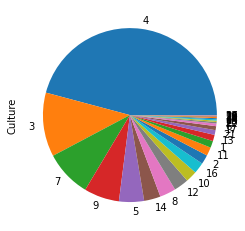

In [10]:
train['Culture'].value_counts().plot.pie()

Выборка несбалансирована, наблюдается преобладание определенного вида культуры (4) 

In [11]:
yeartr = train.Year
yeart = test.Year

In [12]:
one_hot_encoded_yeartr = pd.get_dummies(yeartr)
one_hot_encoded_yeart = pd.get_dummies(yeart)

In [13]:
one_hot_encoded_yeart[2016]=0
one_hot_encoded_yeart = one_hot_encoded_yeart[[2015, 2016, 2017, 2018, 2019]]

In [14]:
days = train.drop(['Culture', 'Year', 'Field ID', 'Field Area'], axis=1)

In [15]:
daystest = test.drop(['Year', 'Field ID', 'Field Area'], axis=1)

In [16]:
# заполняем пропущенные значения с помощью алгоритма к-ближайших соседей (5)
%%time
KNN = KNNImputer(n_neighbors=5, weights="distance")
days = KNN.fit_transform(days)
daytest = KNN.transform(daystest)

UsageError: Line magic function `%%time` not found.


In [17]:
days = pd.DataFrame(days)
daystest = pd.DataFrame(daystest)

In [18]:
days.fillna(value=0)
daystest.fillna(value=0)

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,Day 31,Day 32,Day 33,Day 34,Day 35,Day 36,Day 37,Day 38,Day 39,Day 40,Day 41,Day 42,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,Day 61,Day 62,Day 63,Day 64,Day 65,Day 66,Day 67,Day 68,Day 69,Day 70,Day 71,Day 72,Day 73,Day 74,Day 75,Day 76,Day 77,Day 78,Day 79,Day 80,Day 81,Day 82,Day 83,Day 84,Day 85,Day 86,Day 87,Day 88,Day 89,Day 90,Day 91,Day 92,Day 93,Day 94,Day 95,Day 96,Day 97,Day 98,Day 99,Day 100,Day 101,Day 102,Day 103,Day 104,Day 105,Day 106,Day 107,Day 108,Day 109,Day 110,Day 111,Day 112,Day 113,Day 114,Day 115,Day 116,Day 117,Day 118,Day 119,Day 120,Day 121,Day 122,Day 123,Day 124,Day 125,Day 126,Day 127,Day 128,Day 129,Day 130,Day 131,Day 132,Day 133,Day 134,Day 135,Day 136,Day 137,Day 138,Day 139,Day 140,Day 141,Day 142,Day 143,Day 144,Day 145,Day 146,Day 147,Day 148,Day 149,Day 150,Day 151,Day 152,Day 153,Day 154,Day 155,Day 156,Day 157,Day 158,Day 159,Day 160,Day 161,Day 162,Day 163,Day 164,Day 165,Day 166,Day 167,Day 168,Day 169,Day 170,Day 171,Day 172,Day 173,Day 174,Day 175,Day 176,Day 177,Day 178,Day 179,Day 180,Day 181,Day 182,Day 183,Day 184,Day 185,Day 186,Day 187,Day 188,Day 189,Day 190,Day 191,Day 192,Day 193,Day 194,Day 195,Day 196,Day 197,Day 198,Day 199,Day 200,Day 201,Day 202,Day 203,Day 204,Day 205,Day 206,Day 207,Day 208,Day 209,Day 210,Day 211,Day 212,Day 213,Day 214,Day 215,Day 216,Day 217,Day 218,Day 219,Day 220,Day 221,Day 222,Day 223,Day 224,Day 225,Day 226,Day 227,Day 228,Day 229,Day 230,Day 231,Day 232,Day 233,Day 234,Day 235,Day 236,Day 237,Day 238,Day 239,Day 240,Day 241,Day 242,Day 243,Day 244,Day 245,Day 246,Day 247,Day 248,Day 249,Day 250,Day 251,Day 252,Day 253,Day 254,Day 255,Day 256,Day 257,Day 258,Day 259,Day 260,Day 261,Day 262,Day 263,Day 264,Day 265,Day 266,Day 267,Day 268,Day 269,Day 270,Day 271,Day 272,Day 273,Day 274,Day 275,Day 276,Day 277,Day 278,Day 279,Day 280,Day 281,Day 282,Day 283,Day 284,Day 285,Day 286,Day 287,Day 288,Day 289,Day 290,Day 291,Day 292,Day 293,Day 294,Day 295,Day 296,Day 297,Day 298,Day 299,Day 300,Day 301,Day 302,Day 303,Day 304,Day 305,Day 306,Day 307,Day 308,Day 309,Day 310,Day 311,Day 312,Day 313,Day 314,Day 315,Day 316,Day 317,Day 318,Day 319,Day 320,Day 321,Day 322,Day 323,Day 324,Day 325,Day 326,Day 327,Day 328,Day 329,Day 330,Day 331,Day 332,Day 333,Day 334,Day 335,Day 336,Day 337,Day 338,Day 339,Day 340,Day 341,Day 342,Day 343,Day 344,Day 345,Day 346,Day 347,Day 348,Day 349,Day 350,Day 351,Day 352,Day 353,Day 354,Day 355,Day 356,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366
0,0.5369,0.5371,0.5375,0.5379,0.5384,0.5390,0.5397,0.5405,0.5414,0.5425,0.5437,0.5450,0.5466,0.5487,0.5511,0.5539,0.5571,0.5605,0.5641,0.5679,0.5718,0.5759,0.5800,0.5842,0.5883,0.5924,0.5964,0.6003,0.6040,0.6074,0.6106,0.6135,0.6161,0.6182,0.6200,0.6214,0.6227,0.6238,0.6247,0.6255,0.6261,0.6267,0.6271,0.6274,0.6277,0.6278,0.6279,0.6280,0.6280,0.6280,0.6280,0.6280,0.6277,0.6267,0.6252,0.6233,0.6210,0.6185,0.6158,0.6130,0.6101,0.6073,0.6047,0.6023,0.6003,0.5986,0.5975,0.5969,0.5970,0.5978,0.5994,0.6020,0.6053,0.6091,0.6134,0.6181,0.6231,0.6286,0.6343,0.6404,0.6467,0.6533,0.6601,0.6670,0.6741,0.6813,0.6886,0.6959,0.7032,0.7105,0.7177,0.7249,0.7319,0.7388,0.7455,0.7521,0.7583,0.7643,0.7700,0.7753,0.7805,0.7855,0.7905,0.7954,0.8002,0.8051,0.8099,0.8147,0.8195,0.8243,0.8291,0.8340,0.8389,0.8439,0.8489,0.8540,0.8605,0.8690,0.8783,0.8872,0.8948,0.8997,0.9010,0.8999,0.8987,0.8973,0.8957,0.8941,0.8924,0.8906,0.8887,0.8869,0.8851,0.8833,0.8816,0.8800,0.8785,0.8771,0.8756,0.8742,0.8727,0.8718,0.8716,0.8718,0.8718,0.8712,0.8695,0.8663,0.8610,0.8475,0.8294,0.8136,0.7978,0.7820,0.7662,0.7504,0.7346,0.7188,0.7030,0.6872,0.6714,0.6556,0.6398,0.6240,0.6024,0.5720,0.5366,0.5001,0

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,Day 31,Day 32,Day 33,Day 34,Day 35,Day 36,Day 37,Day 38,Day 39,Day 40,Day 41,Day 42,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,Day 61,Day 62,Day 63,Day 64,Day 65,Day 66,Day 67,Day 68,Day 69,Day 70,Day 71,Day 72,Day 73,Day 74,Day 75,Day 76,Day 77,Day 78,Day 79,Day 80,Day 81,Day 82,Day 83,Day 84,Day 85,Day 86,Day 87,Day 88,Day 89,Day 90,Day 91,Day 92,Day 93,Day 94,Day 95,Day 96,Day 97,Day 98,Day 99,Day 100,Day 101,Day 102,Day 103,Day 104,Day 105,Day 106,Day 107,Day 108,Day 109,Day 110,Day 111,Day 112,Day 113,Day 114,Day 115,Day 116,Day 117,Day 118,Day 119,Day 120,Day 121,Day 122,Day 123,Day 124,Day 125,Day 126,Day 127,Day 128,Day 129,Day 130,Day 131,Day 132,Day 133,Day 134,Day 135,Day 136,Day 137,Day 138,Day 139,Day 140,Day 141,Day 142,Day 143,Day 144,Day 145,Day 146,Day 147,Day 148,Day 149,Day 150,Day 151,Day 152,Day 153,Day 154,Day 155,Day 156,Day 157,Day 158,Day 159,Day 160,Day 161,Day 162,Day 163,Day 164,Day 165,Day 166,Day 167,Day 168,Day 169,Day 170,Day 171,Day 172,Day 173,Day 174,Day 175,Day 176,Day 177,Day 178,Day 179,Day 180,Day 181,Day 182,Day 183,Day 184,Day 185,Day 186,Day 187,Day 188,Day 189,Day 190,Day 191,Day 192,Day 193,Day 194,Day 195,Day 196,Day 197,Day 198,Day 199,Day 200,Day 201,Day 202,Day 203,Day 204,Day 205,Day 206,Day 207,Day 208,Day 209,Day 210,Day 211,Day 212,Day 213,Day 214,Day 215,Day 216,Day 217,Day 218,Day 219,Day 220,Day 221,Day 222,Day 223,Day 224,Day 225,Day 226,Day 227,Day 228,Day 229,Day 230,Day 231,Day 232,Day 233,Day 234,Day 235,Day 236,Day 237,Day 238,Day 239,Day 240,Day 241,Day 242,Day 243,Day 244,Day 245,Day 246,Day 247,Day 248,Day 249,Day 250,Day 251,Day 252,Day 253,Day 254,Day 255,Day 256,Day 257,Day 258,Day 259,Day 260,Day 261,Day 262,Day 263,Day 264,Day 265,Day 266,Day 267,Day 268,Day 269,Day 270,Day 271,Day 272,Day 273,Day 274,Day 275,Day 276,Day 277,Day 278,Day 279,Day 280,Day 281,Day 282,Day 283,Day 284,Day 285,Day 286,Day 287,Day 288,Day 289,Day 290,Day 291,Day 292,Day 293,Day 294,Day 295,Day 296,Day 297,Day 298,Day 299,Day 300,Day 301,Day 302,Day 303,Day 304,Day 305,Day 306,Day 307,Day 308,Day 309,Day 310,Day 311,Day 312,Day 313,Day 314,Day 315,Day 316,Day 317,Day 318,Day 319,Day 320,Day 321,Day 322,Day 323,Day 324,Day 325,Day 326,Day 327,Day 328,Day 329,Day 330,Day 331,Day 332,Day 333,Day 334,Day 335,Day 336,Day 337,Day 338,Day 339,Day 340,Day 341,Day 342,Day 343,Day 344,Day 345,Day 346,Day 347,Day 348,Day 349,Day 350,Day 351,Day 352,Day 353,Day 354,Day 355,Day 356,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366
0,-0.0047,-0.0051,-0.0056,-0.0061,-0.0067,-0.0073,-0.0080,-0.0087,-0.0094,-0.0101,-0.0109,-0.0116,-0.0123,-0.0130,-0.0137,-0.0144,-0.0152,-0.0159,-0.0166,-0.0173,-0.0181,-0.0188,-0.0195,-0.0203,-0.0210,-0.0217,-0.0225,-0.0232,-0.0240,-0.0247,-0.0255,-0.0262,-0.0270,-0.0277,-0.0285,-0.0292,-0.0300,-0.0307,-0.0315,-0.0322,-0.0330,-0.0337,-0.0345,-0.0353,-0.0360,-0.0369,-0.0382,-0.0398,-0.0416,-0.0436,-0.0458,-0.0482,-0.0506,-0.0531,-0.0556,-0.0581,-0.0605,-0.0629,-0.0650,-0.0670,-0.0688,-0.0703,-0.0716,-0.0724,-0.0729,-0.0730,-0.0599,-0.0467,-0.0336,-0.0205,-0.0073,0.0058,0.0189,0.0321,0.0452,0.0583,0.0715,0.0846,0.0977,0.1109,0.1240,0.1371,0.1503,0.1634,0.1765,0.1897,0.2028,0.2159,0.2291,0.2422,0.2553,0.2685,0.2816,0.2947,0.3079,0.3210,0.3311,0.3369,0.3410,0.3460,0.3522,0.3584,0.3647,0.3709,0.3772,0.3834,0.3896,0.3959,0.4021,0.4083,0.4146,0.4208,0.4271,0.4333,0.4395,0.4458,0.4520,0.4583,0.4645,0.4732,0.4861,0.5021,0.5202,0.5393,0.5582,0.5760,0.5942,0.6124,0.6305,0.6487,0.6669,0.6851,0.7032,0.7214,0.7396,0.7578,0.7760,0.7941,0.8123,0.8305,0.8376,0.8372,0.8409,0.8451,0.8497,0.8546,0.8596,0.8647,0.8697,0.8746,0.8790,0.8831,0.8865,0.8893,0.8913,0.8923,0.8922,0.8910,

In [19]:
fa = train.iloc[:, 2]
fat = test.iloc[:, 2]
fa = pd.DataFrame(fa)
fat = pd.DataFrame(fat)

In [21]:
#Cтандартизация
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() 

n_fa = sc.fit_transform(fa)
n_fat = sc.transform(fat)
n_fa
#n_fa = pd.DataFrame(n_fa)

array([[-0.79482512],
       [-0.35921474],
       [-0.863382  ],
       ...,
       [-0.63549894],
       [ 1.79964126],
       [-0.79180862]])

In [23]:
df = one_hot_encoded_yeartr
dft = one_hot_encoded_yeart 

In [24]:
df['FieldA'] = n_fa
dft['FieldA'] = n_fat

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

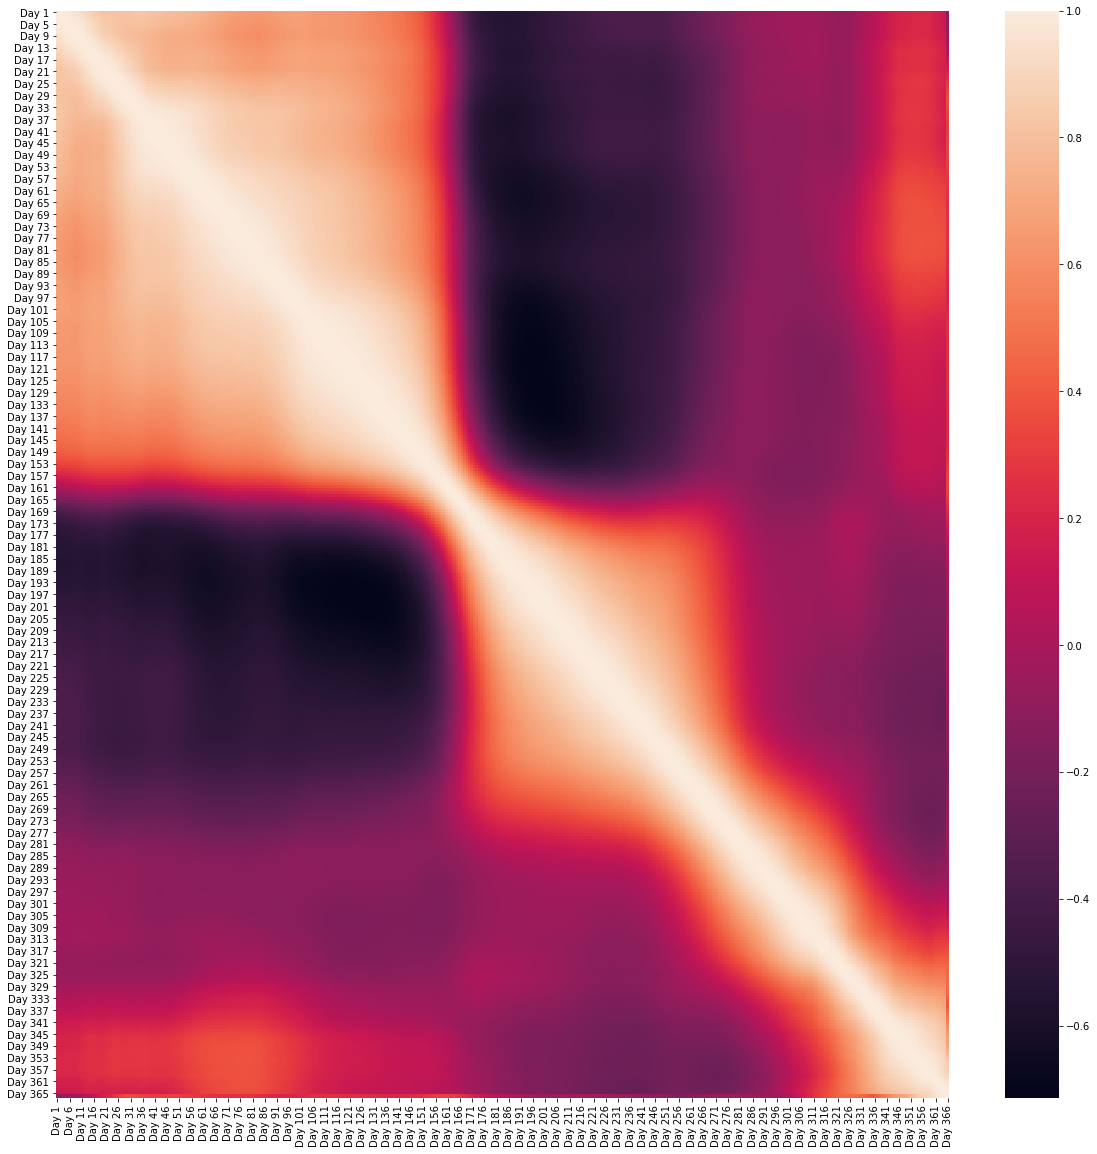

In [27]:
cor = days.corr()
plt.figure(figsize= (20, 20))
sns.heatmap(days.corr())

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

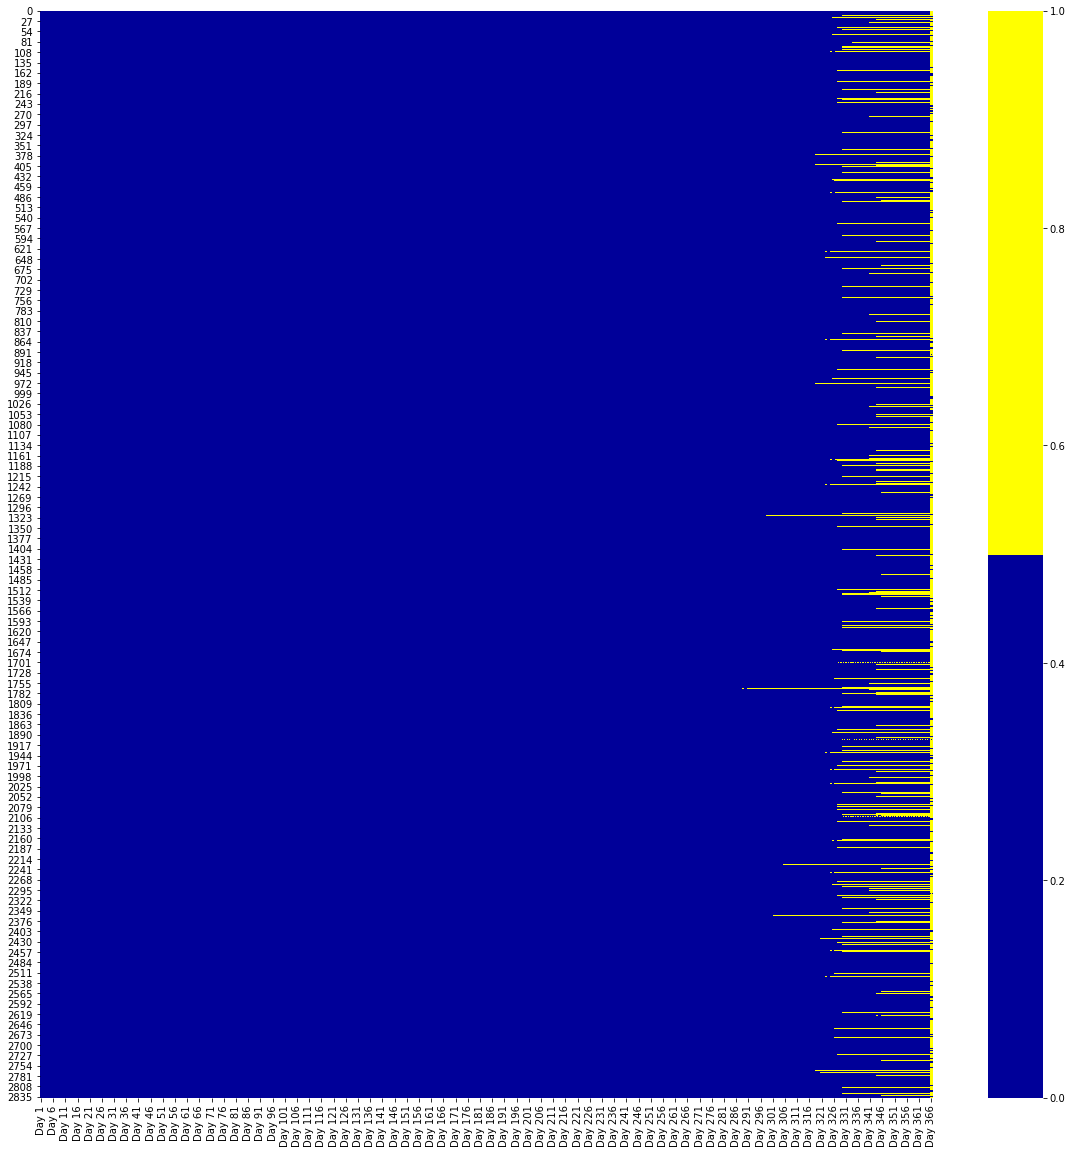

In [28]:
# смотрим на пропущенные значения по дням 
cols = days.columns
colours = ['#000099', '#ffff00']
plt.figure(figsize= (20, 20))
sns.heatmap(days[cols].isnull(), cmap=sns.color_palette(colours))

In [29]:
for col in days.columns:
    pct_missing = np.mean(days[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Day 1 - 0.0%
Day 2 - 0.0%
Day 3 - 0.0%
Day 4 - 0.0%
Day 5 - 0.0%
Day 6 - 0.0%
Day 7 - 0.0%
Day 8 - 0.0%
Day 9 - 0.0%
Day 10 - 0.0%
Day 11 - 0.0%
Day 12 - 0.0%
Day 13 - 0.0%
Day 14 - 0.0%
Day 15 - 0.0%
Day 16 - 0.0%
Day 17 - 0.0%
Day 18 - 0.0%
Day 19 - 0.0%
Day 20 - 0.0%
Day 21 - 0.0%
Day 22 - 0.0%
Day 23 - 0.0%
Day 24 - 0.0%
Day 25 - 0.0%
Day 26 - 0.0%
Day 27 - 0.0%
Day 28 - 0.0%
Day 29 - 0.0%
Day 30 - 0.0%
Day 31 - 0.0%
Day 32 - 0.0%
Day 33 - 0.0%
Day 34 - 0.0%
Day 35 - 0.0%
Day 36 - 0.0%
Day 37 - 0.0%
Day 38 - 0.0%
Day 39 - 0.0%
Day 40 - 0.0%
Day 41 - 0.0%
Day 42 - 0.0%
Day 43 - 0.0%
Day 44 - 0.0%
Day 45 - 0.0%
Day 46 - 0.0%
Day 47 - 0.0%
Day 48 - 0.0%
Day 49 - 0.0%
Day 50 - 0.0%
Day 51 - 0.0%
Day 52 - 0.0%
Day 53 - 0.0%
Day 54 - 0.0%
Day 55 - 0.0%
Day 56 - 0.0%
Day 57 - 0.0%
Day 58 - 0.0%
Day 59 - 0.0%
Day 60 - 0.0%
Day 61 - 0.0%
Day 62 - 0.0%
Day 63 - 0.0%
Day 64 - 0.0%
Day 65 - 0.0%
Day 66 - 0.0%
Day 67 - 0.0%
Day 68 - 0.0%
Day 69 - 0.0%
Day 70 - 0.0%
Day 71 - 0.0%
Day 72 - 0.0%
D

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

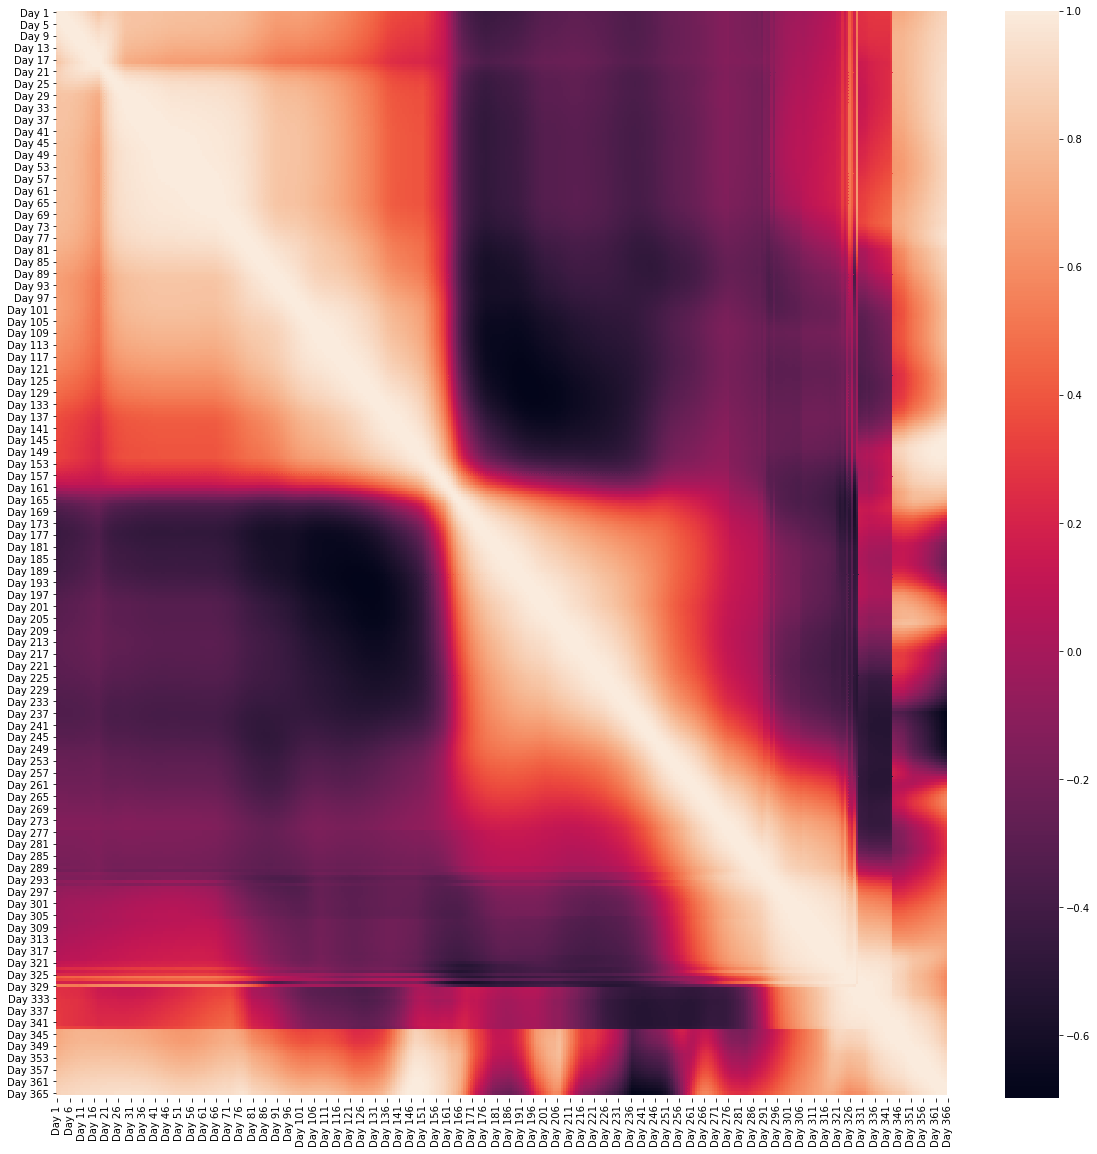

In [30]:
# тот же самый процес делаем и для тестового множества
cort = daystest.corr()
plt.figure(figsize= (20, 20))
sns.heatmap(daystest.corr())

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

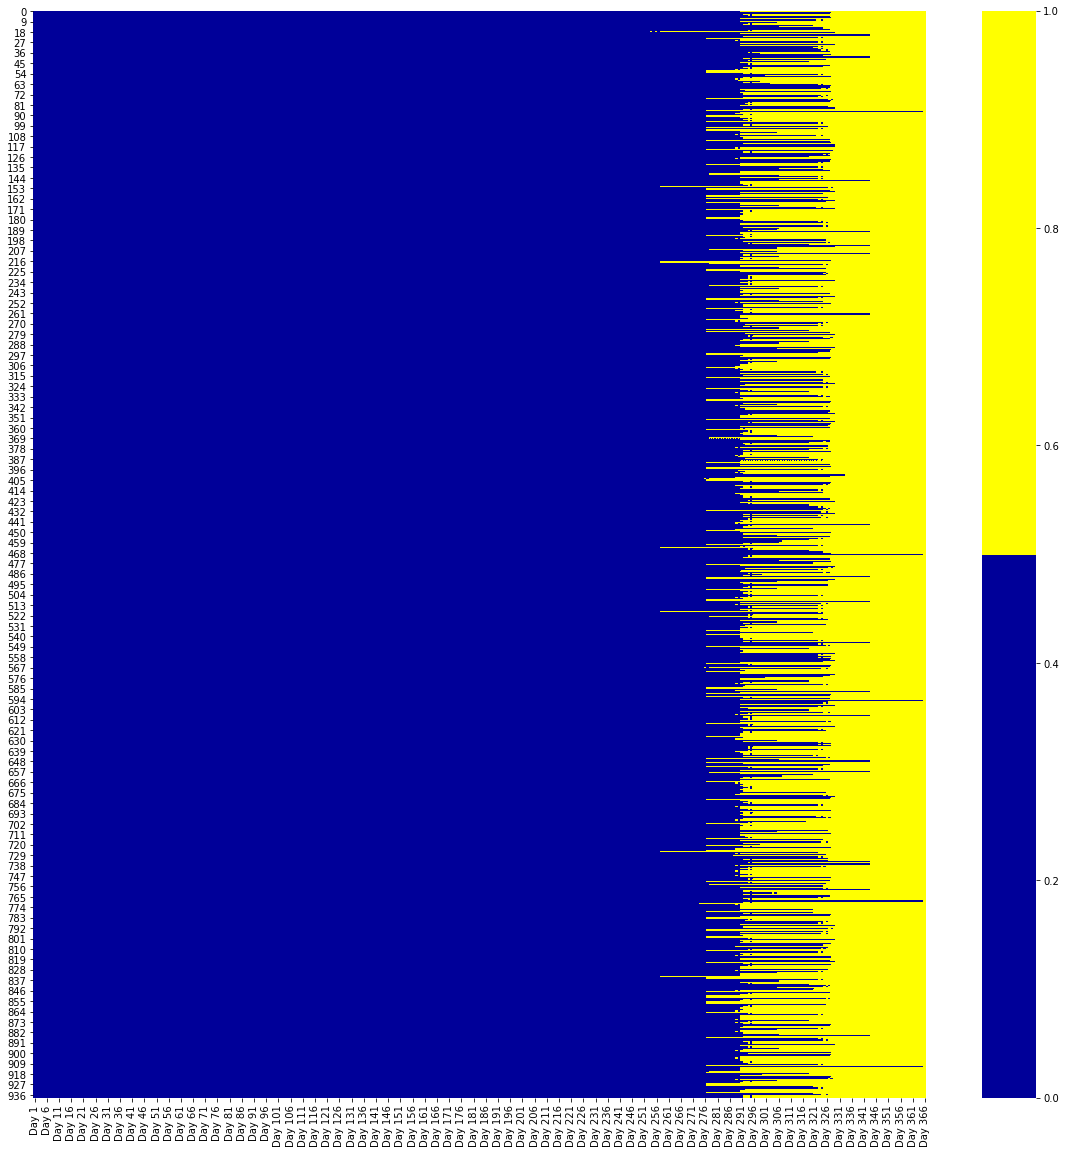

In [31]:
cols = daystest.columns
colours = ['#000099', '#ffff00']
plt.figure(figsize= (20, 20))
sns.heatmap(daystest[cols].isnull(), cmap=sns.color_palette(colours))

In [32]:
for col in days.columns:
    pct_missing = np.mean(daystest[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Day 1 - 0.0%
Day 2 - 0.0%
Day 3 - 0.0%
Day 4 - 0.0%
Day 5 - 0.0%
Day 6 - 0.0%
Day 7 - 0.0%
Day 8 - 0.0%
Day 9 - 0.0%
Day 10 - 0.0%
Day 11 - 0.0%
Day 12 - 0.0%
Day 13 - 0.0%
Day 14 - 0.0%
Day 15 - 0.0%
Day 16 - 0.0%
Day 17 - 0.0%
Day 18 - 0.0%
Day 19 - 0.0%
Day 20 - 0.0%
Day 21 - 0.0%
Day 22 - 0.0%
Day 23 - 0.0%
Day 24 - 0.0%
Day 25 - 0.0%
Day 26 - 0.0%
Day 27 - 0.0%
Day 28 - 0.0%
Day 29 - 0.0%
Day 30 - 0.0%
Day 31 - 0.0%
Day 32 - 0.0%
Day 33 - 0.0%
Day 34 - 0.0%
Day 35 - 0.0%
Day 36 - 0.0%
Day 37 - 0.0%
Day 38 - 0.0%
Day 39 - 0.0%
Day 40 - 0.0%
Day 41 - 0.0%
Day 42 - 0.0%
Day 43 - 0.0%
Day 44 - 0.0%
Day 45 - 0.0%
Day 46 - 0.0%
Day 47 - 0.0%
Day 48 - 0.0%
Day 49 - 0.0%
Day 50 - 0.0%
Day 51 - 0.0%
Day 52 - 0.0%
Day 53 - 0.0%
Day 54 - 0.0%
Day 55 - 0.0%
Day 56 - 0.0%
Day 57 - 0.0%
Day 58 - 0.0%
Day 59 - 0.0%
Day 60 - 0.0%
Day 61 - 0.0%
Day 62 - 0.0%
Day 63 - 0.0%
Day 64 - 0.0%
Day 65 - 0.0%
Day 66 - 0.0%
Day 67 - 0.0%
Day 68 - 0.0%
Day 69 - 0.0%
Day 70 - 0.0%
Day 71 - 0.0%
Day 72 - 0.0%
D

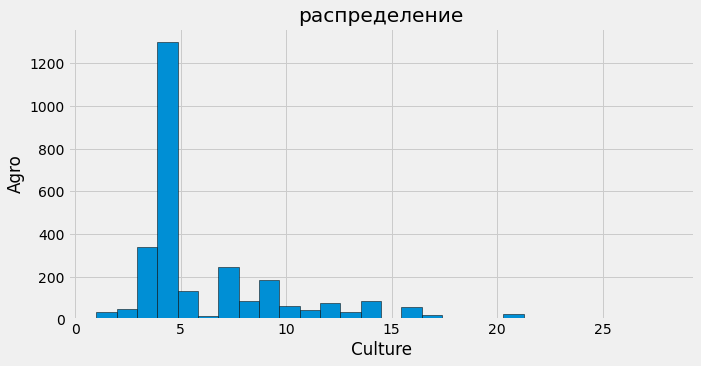

In [35]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize= (10, 5))
plt.hist(train['Culture'].dropna(), bins = 28, edgecolor = 'k');
plt.xlabel('Culture'); plt.ylabel('Agro');
plt.title('распределение');

In [37]:
# смотрим на группы признаков с корреляцией больше заявленной
threshold = 0.85

corr_all = days.corr()
corr_all.loc[:,:] =  np.tril(corr_all, k=-1) 

In [38]:
already_in = set()
result = []
for col in corr_all:
    perfect_corr = corr_all[col][corr_all[col] >= threshold ].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result.append(perfect_corr)

In [39]:
result

[['Day 2',
  'Day 3',
  'Day 4',
  'Day 5',
  'Day 6',
  'Day 7',
  'Day 8',
  'Day 9',
  'Day 10',
  'Day 11',
  'Day 12',
  'Day 13',
  'Day 14',
  'Day 15',
  'Day 16',
  'Day 17',
  'Day 1'],
 ['Day 19',
  'Day 20',
  'Day 21',
  'Day 22',
  'Day 23',
  'Day 24',
  'Day 25',
  'Day 26',
  'Day 27',
  'Day 28',
  'Day 29',
  'Day 30',
  'Day 31',
  'Day 32',
  'Day 33',
  'Day 18'],
 ['Day 35',
  'Day 36',
  'Day 37',
  'Day 38',
  'Day 39',
  'Day 40',
  'Day 41',
  'Day 42',
  'Day 43',
  'Day 44',
  'Day 45',
  'Day 46',
  'Day 47',
  'Day 48',
  'Day 49',
  'Day 50',
  'Day 51',
  'Day 52',
  'Day 53',
  'Day 54',
  'Day 55',
  'Day 56',
  'Day 57',
  'Day 58',
  'Day 59',
  'Day 60',
  'Day 61',
  'Day 62',
  'Day 63',
  'Day 64',
  'Day 65',
  'Day 66',
  'Day 67',
  'Day 68',
  'Day 69',
  'Day 70',
  'Day 71',
  'Day 34'],
 ['Day 73',
  'Day 74',
  'Day 75',
  'Day 76',
  'Day 77',
  'Day 78',
  'Day 79',
  'Day 80',
  'Day 81',
  'Day 82',
  'Day 83',
  'Day 84',
  'Day 85'

При анализе числовых переменных, мы обнаружили, что часть из них имееет прямую корреляцую с другими, поэтому во избежании мультиколлинеарности можем удалитьпеременные корреляцией 1 (одну из группы оставить), либо использовать регуляризацию,
чтобы алгоритм сделал это в автоматичексом режиме.

Как еще мы можем удалить такие переменные без корреляции? 
Все просто, удаляем дубликаты в разрезе столбцов.

In [40]:
train.T.drop_duplicates().T

,Year,Field ID,Field Area,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,Day 31,Day 32,Day 33,Day 34,Day 35,Day 36,Day 37,Day 38,Day 39,Day 40,Day 41,Day 42,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,Day 61,Day 62,Day 63,Day 64,Day 65,Day 66,Day 67,Day 68,Day 69,Day 70,Day 71,Day 72,Day 73,Day 74,Day 75,Day 76,Day 77,Day 78,Day 79,Day 80,Day 81,Day 82,Day 83,Day 84,Day 85,Day 86,Day 87,Day 88,Day 89,Day 90,Day 91,Day 92,Day 93,Day 94,Day 95,Day 96,Day 97,Day 98,Day 99,Day 100,Day 101,Day 102,Day 103,Day 104,Day 105,Day 106,Day 107,Day 108,Day 109,Day 110,Day 111,Day 112,Day 113,Day 114,Day 115,Day 116,Day 117,Day 118,Day 119,Day 120,Day 121,Day 122,Day 123,Day 124,Day 125,Day 126,Day 127,Day 128,Day 129,Day 130,Day 131,Day 132,Day 133,Day 134,Day 135,Day 136,Day 137,Day 138,Day 139,Day 140,Day 141,Day 142,Day 143,Day 144,Day 145,Day 146,Day 147,Day 148,Day 149,Day 150,Day 151,Day 152,Day 153,Day 154,Day 155,Day 156,Day 157,Day 158,Day 159,Day 160,Day 161,Day 162,Day 163,Day 164,Day 165,Day 166,Day 167,Day 168,Day 169,Day 170,Day 171,Day 172,Day 173,Day 174,Day 175,Day 176,Day 177,Day 178,Day 179,Day 180,Day 181,Day 182,Day 183,Day 184,Day 185,Day 186,Day 187,Day 188,Day 189,Day 190,Day 191,Day 192,Day 193,Day 194,Day 195,Day 196,Day 197,Day 198,Day 199,Day 200,Day 201,Day 202,Day 203,Day 204,Day 205,Day 206,Day 207,Day 208,Day 209,Day 210,Day 211,Day 212,Day 213,Day 214,Day 215,Day 216,Day 217,Day 218,Day 219,Day 220,Day 221,Day 222,Day 223,Day 224,Day 225,Day 226,Day 227,Day 228,Day 229,Day 230,Day 231,Day 232,Day 233,Day 234,Day 235,Day 236,Day 237,Day 238,Day 239,Day 240,Day 241,Day 242,Day 243,Day 244,Day 245,Day 246,Day 247,Day 248,Day 249,Day 250,Day 251,Day 252,Day 253,Day 254,Day 255,Day 256,Day 257,Day 258,Day 259,Day 260,Day 261,Day 262,Day 263,Day 264,Day 265,Day 266,Day 267,Day 268,Day 269,Day 270,Day 271,Day 272,Day 273,Day 274,Day 275,Day 276,Day 277,Day 278,Day 279,Day 280,Day 281,Day 282,Day 283,Day 284,Day 285,Day 286,Day 287,Day 288,Day 289,Day 290,Day 291,Day 292,Day 293,Day 294,Day 295,Day 296,Day 297,Day 298,Day 299,Day 300,Day 301,Day 302,Day 303,Day 304,Day 305,Day 306,Day 307,Day 308,Day 309,Day 310,Day 311,Day 312,Day 313,Day 314,Day 315,Day 316,Day 317,Day 318,Day 319,Day 320,Day 321,Day 322,Day 323,Day 324,Day 325,Day 326,Day 327,Day 328,Day 329,Day 330,Day 331,Day 332,Day 333,Day 334,Day 335,Day 336,Day 337,Day 338,Day 339,Day 340,Day 341,Day 342,Day 343,Day 344,Day 345,Day 346,Day 347,Day 348,Day 349,Day 350,Day 351,Day 352,Day 353,Day 354,Day 355,Day 356,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366,Culture
0,2018.0,517.0,48.64,0.5369,0.5371,0.5375,0.5379,0.5384,0.5390,0.5397,0.5405,0.5414,0.5425,0.5437,0.5450,0.5466,0.5487,0.5511,0.5539,0.5571,0.5605,0.5641,0.5679,0.5718,0.5759,0.5800,0.5842,0.5883,0.5924,0.5964,0.6003,0.6040,0.6074,0.6106,0.6135,0.6161,0.6182,0.6200,0.6214,0.6227,0.6238,0.6247,0.6255,0.6261,0.6267,0.6271,0.6274,0.6277,0.6278,0.6279,0.6280,0.6280,0.6280,0.6280,0.6280,0.6277,0.6267,0.6252,0.6233,0.6210,0.6185,0.6158,0.6130,0.6101,0.6073,0.6047,0.6023,0.6003,0.5986,0.5975,0.5969,0.5970,0.5978,0.5994,0.6020,0.6053,0.6091,0.6134,0.6181,0.6231,0.6286,0.6343,0.6404,0.6467,0.6533,0.6601,0.6670,0.6741,0.6813,0.6886,0.6959,0.7032,0.7105,0.7177,0.7249,0.7319,0.7388,0.7455,0.7521,0.7583,0.7643,0.7700,0.7753,0.7805,0.7855,0.7905,0.7954,0.8002,0.8051,0.8099,0.8147,0.8195,0.8243,0.8291,0.8340,0.8389,0.8439,0.8489,0.8540,0.8605,0.8690,0.8783,0.8872,0.8948,0.8997,0.9010,0.8999,0.8987,0.8973,0.8957,0.8941,0.8924,0.8906,0.8887,0.8869,0.8851,0.8833,0.8816,0.8800,0.8785,0.8771,0.8756,0.8742,0.8727,0.8718,0.8716,0.8718,0.8718,0.8712,0.8695,0.8663,0.8610,0.8475,0.8294,0.8136,0.7978,0.7820,0.7662,0.7504,0.7346,0.7188,0.7030,0.6872,0.671

In [41]:
train.stb.freq(['Culture'])[:28]

,Culture,Count,Percent,Cumulative Count,Cumulative Percent
0,4,1301,0.458421,1301,0.458421
1,3,338,0.119098,1639,0.577519
2,7,246,0.086681,1885,0.664200
3,9,186,0.065539,2071,0.729739
4,5,132,0.046512,2203,0.776251
5,14,87,0.030655,2290,0.806906
6,8,85,0.029951,2375,0.836857
7,12,78,0.027484,2453,0.864341
8,10,60,0.021142,2513,0.885483
9,16,58,0.020437,2571,0.905920


In [42]:
train.stb.freq(['Culture'], thresh=.9, other_label='other culture')

,Culture,Count,Percent,Cumulative Count,Cumulative Percent
0,4.0,1301,0.458421,1301,0.458421
1,3.0,338,0.119098,1639,0.577519
2,7.0,246,0.086681,1885,0.664200
3,9.0,186,0.065539,2071,0.729739
4,5.0,132,0.046512,2203,0.776251
5,14.0,87,0.030655,2290,0.806906
6,8.0,85,0.029951,2375,0.836857
7,12.0,78,0.027484,2453,0.864341
8,10.0,60,0.021142,2513,0.885483
9,other culture,325,0.114517,2838,1.000000


In [43]:
train.stb.freq(['Culture'], value='Field Area', thresh=.95, style=True)

,Culture,Field Area,Percent,Cumulative Field Area,Cumulative Percent
0,4.000000,"125,103",41.35%,"125,103",41.35%
1,3.000000,"42,960",14.20%,"168,063",55.55%
2,9.000000,"23,048",7.62%,"191,111",63.17%
3,7.000000,"22,975",7.59%,"214,087",70.76%
4,5.000000,"16,733",5.53%,"230,819",76.29%
5,8.000000,"11,399",3.77%,"242,218",80.06%
6,12.000000,"8,722",2.88%,"250,940",82.94%
7,14.000000,"7,482",2.47%,"258,422",85.41%
8,2.000000,"6,875",2.27%,"265,296",87.69%
9,16.000000,"6,579",2.17%,"271,875",89.86%


In [ ]:
# непугайтесь сделано для удобства и не вручную :)
'Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Day 6', 
'Day 8', 'Day 9', 'Day 10', 'Day 11','Day 12', 'Day 13', 
'Day 15', 'Day 16', 'Day 17', 'Day 18','Day 19', 'Day 20', 
'Day 22', 'Day 23', 'Day 24', 'Day 25','Day 26', 'Day 27', 
'Day 29', 'Day 30', 'Day 31', 'Day 32','Day 33', 'Day 34', 
'Day 36', 'Day 37', 'Day 38', 'Day 39','Day 40', 'Day 41', 
'Day 42', 'Day 43', 'Day 44', 'Day 45','Day 46', 'Day 47', 
'Day 49', 'Day 50', 'Day 51', 'Day 52','Day 53', 'Day 54', 
'Day 56', 'Day 57', 'Day 58', 'Day 59','Day 60', 'Day 61', 
'Day 63', 'Day 64', 'Day 65', 'Day 66','Day 67', 'Day 68', 
'Day 70', 'Day 71', 'Day 72', 'Day 73','Day 74', 'Day 75', 
'Day 77', 'Day 78', 'Day 79', 'Day 80','Day 81', 'Day 82', 
'Day 84', 'Day 85', 'Day 86', 'Day 87','Day 88', 'Day 89', 
'Day 91', 'Day 92', 'Day 93', 'Day 94','Day 95', 'Day 96', 
'Day 98', 'Day 99', 'Day 100', 'Day 101','Day 102', 'Day 103', 
'Day 105', 'Day 106', 'Day 107', 'Day 108','Day 109', 'Day 110', 
'Day 112', 'Day 113', 'Day 114', 'Day 115','Day 116', 'Day 117', 
'Day 119', 'Day 120', 'Day 121', 'Day 122','Day 123', 'Day 124', 
'Day 126', 'Day 127', 'Day 128', 'Day 129','Day 130', 'Day 131', 
'Day 133', 'Day 134', 'Day 135', 'Day 136','Day 137', 'Day 138', 
'Day 140', 'Day 141', 'Day 142', 'Day 143','Day 144', 'Day 145', 
'Day 147', 'Day 148', 'Day 149', 'Day 150','Day 151', 'Day 152', 
'Day 154', 'Day 155', 'Day 156', 'Day 157','Day 158', 'Day 159', 
'Day 161', 'Day 162', 'Day 163', 'Day 164','Day 165', 'Day 166', 
'Day 168', 'Day 169', 'Day 170', 'Day 171','Day 172', 'Day 173', 
'Day 175', 'Day 176', 'Day 177', 'Day 178','Day 179', 'Day 180', 
'Day 182', 'Day 183', 'Day 184', 'Day 185','Day 186', 'Day 187', 
'Day 189', 'Day 190', 'Day 191', 'Day 192','Day 193', 'Day 194', 
'Day 196', 'Day 197', 'Day 198', 'Day 199','Day 200', 'Day 201', 
'Day 203', 'Day 204', 'Day 205', 'Day 206','Day 207', 'Day 208', 
'Day 210', 'Day 211', 'Day 212', 'Day 213','Day 214', 'Day 215', 
'Day 217', 'Day 218', 'Day 219', 'Day 220','Day 221', 'Day 222', 
'Day 224', 'Day 225', 'Day 226', 'Day 227','Day 228', 'Day 229', 
'Day 231', 'Day 232', 'Day 233', 'Day 234','Day 235', 'Day 236', 
'Day 238', 'Day 239', 'Day 240', 'Day 241','Day 242', 'Day 243', 
'Day 245', 'Day 246', 'Day 247', 'Day 248','Day 249', 'Day 250', 
'Day 252', 'Day 253', 'Day 254', 'Day 255','Day 256', 'Day 257', 
'Day 259', 'Day 260', 'Day 261', 'Day 262','Day 263', 'Day 264', 
'Day 266', 'Day 267', 'Day 268', 'Day 269','Day 270', 'Day 271', 
'Day 273', 'Day 274', 'Day 275', 'Day 276','Day 277', 'Day 278', 
'Day 280', 'Day 281', 'Day 282', 'Day 283','Day 284', 'Day 285', 
'Day 287', 'Day 288', 'Day 289', 'Day 290','Day 291', 'Day 292', 
'Day 294', 'Day 295', 'Day 296', 'Day 297','Day 298', 'Day 299', 
'Day 301', 'Day 302', 'Day 303', 'Day 304','Day 305', 'Day 306', 
'Day 308', 'Day 309', 'Day 310', 'Day 311','Day 312', 'Day 313', 
'Day 315', 'Day 316', 'Day 317', 'Day 318','Day 319', 'Day 320', 
'Day 322', 'Day 323', 'Day 324', 'Day 325','Day 326', 'Day 327', 
'Day 329', 'Day 330', 'Day 331', 'Day 332','Day 333', 'Day 334', 
'Day 336', 'Day 337', 'Day 338', 'Day 339','Day 340', 'Day 341', 
'Day 343', 'Day 344', 'Day 345', 'Day 346','Day 347', 'Day 348', 
'Day 350', 'Day 351', 'Day 352', 'Day 353','Day 354', 'Day 355', 
'Day 357', 'Day 358', 'Day 359', 'Day 360','Day 361', 'Day 362', 
'Day 364', 'Day 365', 'Day 366'

In [44]:
da = days.drop(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Day 6', 
'Day 8', 'Day 9', 'Day 10', 'Day 11','Day 12', 'Day 13', 
'Day 15', 'Day 16', 'Day 17', 'Day 18','Day 19', 'Day 20', 
'Day 22', 'Day 23', 'Day 24', 'Day 25','Day 26', 'Day 27', 
'Day 29', 'Day 30', 'Day 31', 'Day 32','Day 33', 'Day 34', 
'Day 36', 'Day 37', 'Day 38', 'Day 39','Day 40', 'Day 41', 
'Day 42', 'Day 43', 'Day 44', 'Day 45','Day 46', 'Day 47', 
'Day 49', 'Day 50', 'Day 51', 'Day 52','Day 53', 'Day 54', 
'Day 56', 'Day 57', 'Day 58', 'Day 59','Day 60', 'Day 61', 
'Day 63', 'Day 64', 'Day 65', 'Day 66','Day 67', 'Day 68', 
'Day 70', 'Day 71', 'Day 72', 'Day 73','Day 74', 'Day 75', 
'Day 77', 'Day 78', 'Day 79', 'Day 80','Day 81', 'Day 82', 
'Day 84', 'Day 85', 'Day 86', 'Day 87','Day 88', 'Day 89', 
'Day 91', 'Day 92', 'Day 93', 'Day 94','Day 95', 'Day 96', 
'Day 98', 'Day 99', 'Day 100', 'Day 101','Day 102', 'Day 103', 
'Day 105', 'Day 106', 'Day 107', 'Day 108','Day 109', 'Day 110', 
'Day 112', 'Day 113', 'Day 114', 'Day 115','Day 116', 'Day 117', 
'Day 119', 'Day 120', 'Day 121', 'Day 122','Day 123', 'Day 124', 
'Day 126', 'Day 127', 'Day 128', 'Day 129','Day 130', 'Day 131', 
'Day 133', 'Day 134', 'Day 135', 'Day 136','Day 137', 'Day 138', 
'Day 140', 'Day 141', 'Day 142', 'Day 143','Day 144', 'Day 145', 
'Day 147', 'Day 148', 'Day 149', 'Day 150','Day 151', 'Day 152', 
'Day 154', 'Day 155', 'Day 156', 'Day 157','Day 158', 'Day 159', 
'Day 161', 'Day 162', 'Day 163', 'Day 164','Day 165', 'Day 166', 
'Day 168', 'Day 169', 'Day 170', 'Day 171','Day 172', 'Day 173', 
'Day 175', 'Day 176', 'Day 177', 'Day 178','Day 179', 'Day 180', 
'Day 182', 'Day 183', 'Day 184', 'Day 185','Day 186', 'Day 187', 
'Day 189', 'Day 190', 'Day 191', 'Day 192','Day 193', 'Day 194', 
'Day 196', 'Day 197', 'Day 198', 'Day 199','Day 200', 'Day 201', 
'Day 203', 'Day 204', 'Day 205', 'Day 206','Day 207', 'Day 208', 
'Day 210', 'Day 211', 'Day 212', 'Day 213','Day 214', 'Day 215', 
'Day 217', 'Day 218', 'Day 219', 'Day 220','Day 221', 'Day 222', 
'Day 224', 'Day 225', 'Day 226', 'Day 227','Day 228', 'Day 229', 
'Day 231', 'Day 232', 'Day 233', 'Day 234','Day 235', 'Day 236', 
'Day 238', 'Day 239', 'Day 240', 'Day 241','Day 242', 'Day 243', 
'Day 245', 'Day 246', 'Day 247', 'Day 248','Day 249', 'Day 250', 
'Day 252', 'Day 253', 'Day 254', 'Day 255','Day 256', 'Day 257', 
'Day 259', 'Day 260', 'Day 261', 'Day 262','Day 263', 'Day 264', 
'Day 266', 'Day 267', 'Day 268', 'Day 269','Day 270', 'Day 271', 
'Day 273', 'Day 274', 'Day 275', 'Day 276','Day 277', 'Day 278', 
'Day 280', 'Day 281', 'Day 282', 'Day 283','Day 284', 'Day 285', 
'Day 287', 'Day 288', 'Day 289', 'Day 290','Day 291', 'Day 292', 
'Day 294', 'Day 295', 'Day 296', 'Day 297','Day 298', 'Day 299', 
'Day 301', 'Day 302', 'Day 303', 'Day 304','Day 305', 'Day 306', 
'Day 308', 'Day 309', 'Day 310', 'Day 311','Day 312', 'Day 313', 
'Day 315', 'Day 316', 'Day 317', 'Day 318','Day 319', 'Day 320', 
'Day 322', 'Day 323', 'Day 324', 'Day 325','Day 326', 'Day 327', 
'Day 329', 'Day 330', 'Day 331', 'Day 332','Day 333', 'Day 334', 
'Day 336', 'Day 337', 'Day 338', 'Day 339','Day 340', 'Day 341', 
'Day 343', 'Day 344', 'Day 345', 'Day 346','Day 347', 'Day 348', 
'Day 350', 'Day 351', 'Day 352', 'Day 353','Day 354', 'Day 355', 
'Day 357', 'Day 358', 'Day 359', 'Day 360','Day 361', 'Day 362', 
'Day 364', 'Day 365', 'Day 366'], axis=1)

In [45]:
dat = daystest.drop(['Day 1', 'Day 2', 'Day 3', 'Day 4','Day 5', 'Day 6', 
'Day 8', 'Day 9', 'Day 10', 'Day 11','Day 12', 'Day 13', 
'Day 15', 'Day 16', 'Day 17', 'Day 18','Day 19', 'Day 20', 
'Day 22', 'Day 23', 'Day 24', 'Day 25','Day 26', 'Day 27', 
'Day 29', 'Day 30', 'Day 31', 'Day 32','Day 33', 'Day 34', 
'Day 36', 'Day 37', 'Day 38', 'Day 39','Day 40', 'Day 41', 
'Day 42', 'Day 43', 'Day 44', 'Day 45','Day 46', 'Day 47', 
'Day 49', 'Day 50', 'Day 51', 'Day 52','Day 53', 'Day 54', 
'Day 56', 'Day 57', 'Day 58', 'Day 59','Day 60', 'Day 61', 
'Day 63', 'Day 64', 'Day 65', 'Day 66','Day 67', 'Day 68', 
'Day 70', 'Day 71', 'Day 72', 'Day 73','Day 74', 'Day 75', 
'Day 77', 'Day 78', 'Day 79', 'Day 80','Day 81', 'Day 82', 
'Day 84', 'Day 85', 'Day 86', 'Day 87','Day 88', 'Day 89', 
'Day 91', 'Day 92', 'Day 93', 'Day 94','Day 95', 'Day 96', 
'Day 98', 'Day 99', 'Day 100', 'Day 101','Day 102', 'Day 103', 
'Day 105', 'Day 106', 'Day 107', 'Day 108','Day 109', 'Day 110', 
'Day 112', 'Day 113', 'Day 114', 'Day 115','Day 116', 'Day 117', 
'Day 119', 'Day 120', 'Day 121', 'Day 122','Day 123', 'Day 124', 
'Day 126', 'Day 127', 'Day 128', 'Day 129','Day 130', 'Day 131', 
'Day 133', 'Day 134', 'Day 135', 'Day 136','Day 137', 'Day 138', 
'Day 140', 'Day 141', 'Day 142', 'Day 143','Day 144', 'Day 145', 
'Day 147', 'Day 148', 'Day 149', 'Day 150','Day 151', 'Day 152', 
'Day 154', 'Day 155', 'Day 156', 'Day 157','Day 158', 'Day 159', 
'Day 161', 'Day 162', 'Day 163', 'Day 164','Day 165', 'Day 166', 
'Day 168', 'Day 169', 'Day 170', 'Day 171','Day 172', 'Day 173', 
'Day 175', 'Day 176', 'Day 177', 'Day 178','Day 179', 'Day 180', 
'Day 182', 'Day 183', 'Day 184', 'Day 185','Day 186', 'Day 187', 
'Day 189', 'Day 190', 'Day 191', 'Day 192','Day 193', 'Day 194', 
'Day 196', 'Day 197', 'Day 198', 'Day 199','Day 200', 'Day 201', 
'Day 203', 'Day 204', 'Day 205', 'Day 206','Day 207', 'Day 208', 
'Day 210', 'Day 211', 'Day 212', 'Day 213','Day 214', 'Day 215', 
'Day 217', 'Day 218', 'Day 219', 'Day 220','Day 221', 'Day 222', 
'Day 224', 'Day 225', 'Day 226', 'Day 227','Day 228', 'Day 229', 
'Day 231', 'Day 232', 'Day 233', 'Day 234','Day 235', 'Day 236', 
'Day 238', 'Day 239', 'Day 240', 'Day 241','Day 242', 'Day 243', 
'Day 245', 'Day 246', 'Day 247', 'Day 248','Day 249', 'Day 250', 
'Day 252', 'Day 253', 'Day 254', 'Day 255','Day 256', 'Day 257', 
'Day 259', 'Day 260', 'Day 261', 'Day 262','Day 263', 'Day 264', 
'Day 266', 'Day 267', 'Day 268', 'Day 269','Day 270', 'Day 271', 
'Day 273', 'Day 274', 'Day 275', 'Day 276','Day 277', 'Day 278', 
'Day 280', 'Day 281', 'Day 282', 'Day 283','Day 284', 'Day 285', 
'Day 287', 'Day 288', 'Day 289', 'Day 290','Day 291', 'Day 292', 
'Day 294', 'Day 295', 'Day 296', 'Day 297','Day 298', 'Day 299', 
'Day 301', 'Day 302', 'Day 303', 'Day 304','Day 305', 'Day 306', 
'Day 308', 'Day 309', 'Day 310', 'Day 311','Day 312', 'Day 313', 
'Day 315', 'Day 316', 'Day 317', 'Day 318','Day 319', 'Day 320', 
'Day 322', 'Day 323', 'Day 324', 'Day 325','Day 326', 'Day 327', 
'Day 329', 'Day 330', 'Day 331', 'Day 332','Day 333', 'Day 334', 
'Day 336', 'Day 337', 'Day 338', 'Day 339','Day 340', 'Day 341', 
'Day 343', 'Day 344', 'Day 345', 'Day 346','Day 347', 'Day 348', 
'Day 350', 'Day 351', 'Day 352', 'Day 353','Day 354', 'Day 355', 
'Day 357', 'Day 358', 'Day 359', 'Day 360','Day 361', 'Day 362', 
'Day 364', 'Day 365', 'Day 366'], axis=1)

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

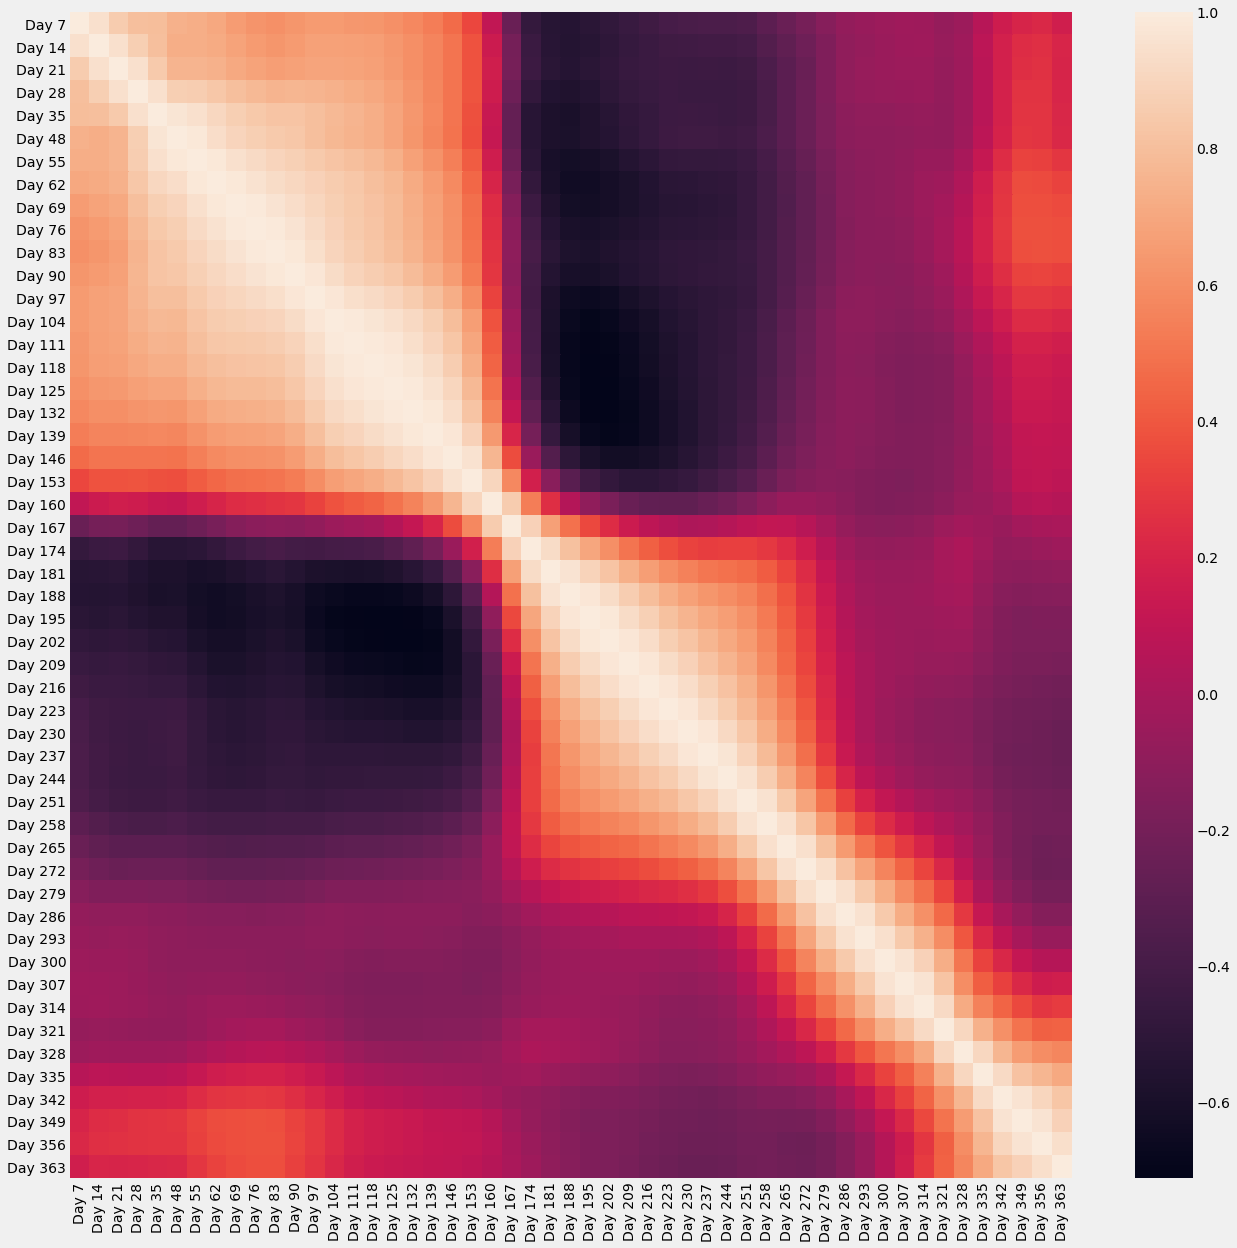

In [46]:
cor = da.corr()
plt.figure(figsize= (20, 20))
sns.heatmap(da.corr())

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

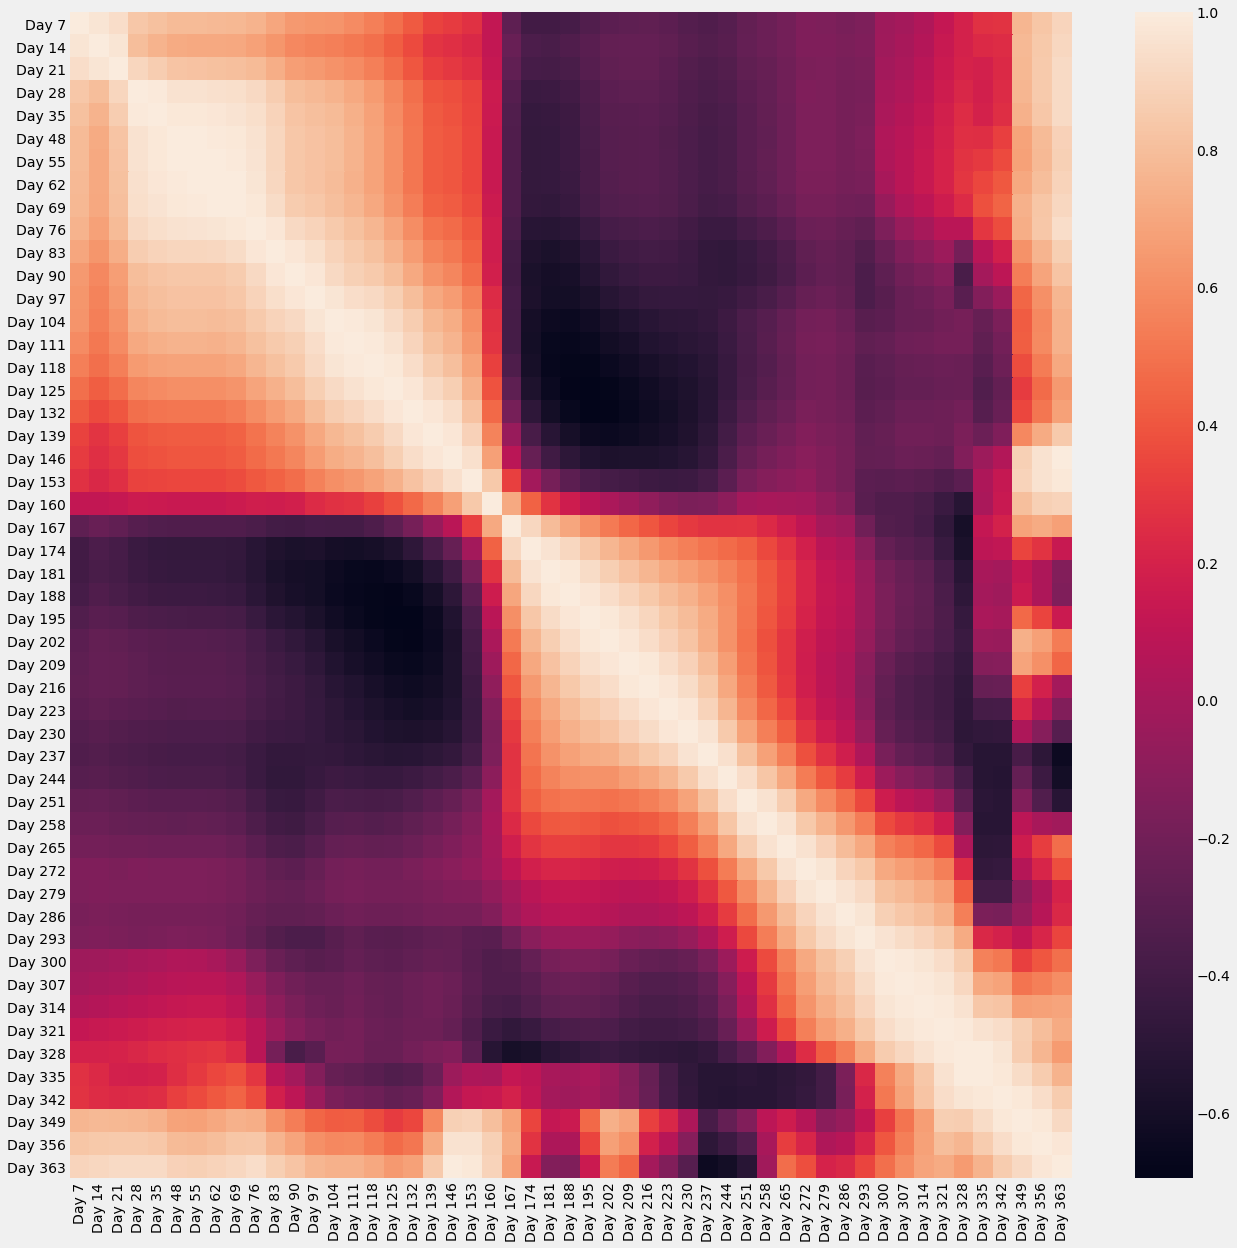

In [47]:
cor = dat.corr()
plt.figure(figsize= (20, 20))
sns.heatmap(dat.corr())

In [55]:
x_train = pd.concat((df, da), axis=1)

In [56]:
x_train

,2015,2016,2017,2018,2019,FieldA,Day 7,Day 14,Day 21,Day 28,Day 35,Day 48,Day 55,Day 62,Day 69,Day 76,Day 83,Day 90,Day 97,Day 104,Day 111,Day 118,Day 125,Day 132,Day 139,Day 146,Day 153,Day 160,Day 167,Day 174,Day 181,Day 188,Day 195,Day 202,Day 209,Day 216,Day 223,Day 230,Day 237,Day 244,Day 251,Day 258,Day 265,Day 272,Day 279,Day 286,Day 293,Day 300,Day 307,Day 314,Day 321,Day 328,Day 335,Day 342,Day 349,Day 356,Day 363
0,0,0,0,1,0,-0.794825,0.5397,0.5487,0.5718,0.6003,0.6200,0.6280,0.6252,0.6073,0.5970,0.6181,0.6601,0.7105,0.7583,0.7954,0.8291,0.8690,0.8987,0.8869,0.8756,0.8712,0.7978,0.6872,0.5366,0.4111,0.3809,0.3507,0.3232,0.3142,0.3136,0.3098,0.2988,0.2460,0.2460,0.2223,0.2260,0.2732,0.2947,0.3098,0.3241,0.3374,0.3520,0.3720,0.3629,0.3359,0.3481,0.3700,0.4092,0.4555,0.4720,0.4442,0.4163
1,0,0,0,0,1,-0.359215,0.0783,0.0345,-0.0040,-0.0062,-0.0090,-0.0163,-0.0343,-0.0511,-0.0424,0.0162,0.0810,0.1452,0.2068,0.2674,0.3279,0.3926,0.5124,0.6670,0.7596,0.6967,0.6339,0.6222,0.6786,0.7350,0.7420,0.7488,0.7457,0.7332,0.7196,0.7046,0.6869,0.7363,0.7120,0.5367,0.3908,0.4030,0.4178,0.4176,0.3808,0.3461,0.3345,0.3412,0.3465,0.3507,0.3322,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,0,0,-0.863382,-0.0220,-0.0234,-0.0242,-0.0249,-0.0256,-0.0408,0.0103,0.0672,0.1240,0.1718,0.1974,0.2260,0.2497,0.2395,0.2452,0.2661,0.3048,0.3351,0.3540,0.3406,0.3645,0.4699,0.6273,0.7316,0.7810,0.7878,0.7920,0.7383,0.6847,0.5901,0.4677,0.4092,0.3508,0.3116,0.3079,0.3069,0.3079,0.3188,0.3558,0.4054,0.4040,0.4252,0.4464,0.4676,0.4888,0.1753,0.0376,0.0318,0.0259,0.0200,0.2415
3,0,0,0,1,0,-0.373886,0.3318,0.2051,0.0980,-0.0090,0.3526,0.5163,0.5224,0.5285,0.5028,0.5399,0.6016,0.6300,0.6589,0.6985,0.7483,0.7945,0.8050,0.8110,0.7791,0.7387,0.6688,0.4642,0.3699,0.3050,0.2704,0.2358,0.2210,0.2210,0.2254,0.2746,0.3161,0.3531,0.3475,0.3063,0.2574,0.2293,0.2184,0.2167,0.2154,0.2141,0.2131,0.2122,0.2359,0.2599,0.2580,0.2565,0.2568,0.2574,0.2585,0.2636,0.2717
4,0,0,1,0,0,0.523112,-0.0140,-0.0097,-0.0118,-0.0147,-0.0156,-0.0170,-0.0225,-0.0313,-0.0410,-0.0495,-0.0570,-0.0616,0.0037,0.1644,0.3174,0.4267,0.5069,0.5871,0.6849,0.7634,0.8228,0.8700,0.8699,0.8691,0.8455,0.8186,0.7918,0.6569,0.5040,0.4028,0.3094,0.3350,0.3216,0.3067,0.3305,0.3440,0.3464,0.3255,0.2882,0.2883,0.3199,0.3275,0.3227,0.2888,0.2323,0.1758,0.1193,0.0628,0.0063,-0.0364,-0.0372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0,0,0,0,1,0.143033,0.4431,0.4431,0.4427,0.4411,0.4381,0.4082,0.4031,0.4178,0.4462,0.4812,0.5207,0.5596,0.6172,0.7004,0.7842,0.8323,0.8387,0.8420,0.8063,0.7425,0.6675,0.5265,0.3899,0.3300,0.2961,0.2699,0.2342,0.2907,0.3505,0.3098,0.2552,0.2283,0.2249,0.2177,0.2128,0.2379,0.3110,0.3841,0.4584,0.4891,0.4938,0.5033,0.4664,0.3793,0.2718,0.2568,0.2520,0.2471,NaN,NaN,NaN
2834,0,1,0,0,0,-0.493586,0.1025,0.1498,0.1970,0.2443,0.2915,0.3792,0.4133,0.4315,0.4495,0.4726,0.4955,0.5184,0.5546,0.6608,0.7464,0.7741,0.7966,0.8191,0.8387,0.8464,0.8284,0.7990,0.7667,0.7203,0.6347,0.5443,0.4589,0.3963,0.3902,0.3839,0.3672,0.3400,0.3051,0.2951,0.2982,0.2988,0.3267,0.3565,0.3868,0.4187,0.4506,0.4535,0.4360,0.4185,0.3820,0.3025,0.3103,0.3182,0.3260,0.0329,0.0699
2835,0,1,0,0,0,-0.635499,0.0093,0.0418,0.1306,0.2427,0.3339,0.3453,0.3607,0.3773,0.3975,0.4425,0.4860,0.4912,0.5033,0.5768,0.6639,0.7326,0.7908,0.7856,0.7805,0.7823,0.7941,0.7714,0.7238,0.6741,0.6046,0.5284,0.4492,0.4139,0.4207,0.4291,0.4624,0.4048,0.3445,0.2936,0.2827,0.2792,0.2807,0.2829,0.2854,0.2891,0.2942,0.3020,0.3389,0.3857,0.3724,0.3240,0.0676,0.2008,0.3990,0.3651,0.3313
2836,0,0,1,0,0,1.799641,-0.0155,-0.0169,-0.0195,-0.0231,-0.0269,-0.0508,0.0256,0.1178,0.2100,0.2520,0.2564,0.2608,0.2665,0.2846,0.2822,0.2775,0.3545,0.4660,0.5764,0.6822,0.7742,0.7996,0.7813,0.7644,0.7323,0.6530,0.5737,0.4417,0.2850,0.2579,0.2294,0.1983,0.1936,0.1888,0.1840,0.1898,0.2111,0.2261,0.248

In [53]:
x_test = pd.concat((dft, dat), axis=1) 

In [54]:
x_test

,2015,2016,2017,2018,2019,FieldA,Day 7,Day 14,Day 21,Day 28,Day 35,Day 48,Day 55,Day 62,Day 69,Day 76,Day 83,Day 90,Day 97,Day 104,Day 111,Day 118,Day 125,Day 132,Day 139,Day 146,Day 153,Day 160,Day 167,Day 174,Day 181,Day 188,Day 195,Day 202,Day 209,Day 216,Day 223,Day 230,Day 237,Day 244,Day 251,Day 258,Day 265,Day 272,Day 279,Day 286,Day 293,Day 300,Day 307,Day 314,Day 321,Day 328,Day 335,Day 342,Day 349,Day 356,Day 363
0,0,0,0,0,1,0.356382,-0.0080,-0.0130,-0.0181,-0.0232,-0.0285,-0.0398,-0.0556,-0.0703,-0.0336,0.0583,0.1503,0.2422,0.3311,0.3709,0.4146,0.4583,0.5582,0.6851,0.8123,0.8546,0.8865,0.8794,0.8390,0.7985,0.7125,0.6025,0.4812,0.4070,0.3872,0.3254,0.2636,0.2018,0.2253,0.2513,0.2390,0.2222,0.2390,0.2344,0.2287,0.2226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,1,-0.619320,0.2403,0.2353,0.2328,0.2998,0.3047,0.3048,0.3122,0.3211,0.3296,0.3355,0.3368,0.3330,0.3275,0.3106,0.2984,0.3210,0.3490,0.4752,0.6015,0.7365,0.8229,0.8070,0.8100,0.7806,0.7468,0.7723,0.8052,0.8299,0.7773,0.7338,0.7115,0.6774,0.6371,0.6097,0.6002,0.6060,0.6214,0.6487,0.5704,0.3706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,0,1,-0.649210,-0.0133,-0.0211,-0.0290,-0.0368,-0.0447,-0.0592,-0.0697,-0.0812,-0.0820,-0.0392,0.0208,0.0836,0.1463,0.2090,0.2718,0.3260,0.3520,0.3812,0.4190,0.5074,0.6066,0.6908,0.7426,0.7945,0.8271,0.8116,0.8045,0.8215,0.8325,0.7870,0.7262,0.5738,0.4538,0.3581,0.2624,0.1959,0.2025,0.2092,0.2040,0.1655,0.1556,0.1574,0.1580,0.1584,0.1584,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,1,0.078864,-0.0221,-0.0097,0.0330,0.0890,0.1450,0.2490,0.2416,0.2341,0.2403,0.2717,0.2832,0.2810,0.2805,0.2862,0.3000,0.3314,0.3820,0.4430,0.5065,0.5736,0.6657,0.8100,0.8131,0.8049,0.7785,0.7791,0.7973,0.7805,0.6927,0.6036,0.4630,0.3531,0.2563,0.2032,0.1862,0.1713,0.1826,0.1869,0.1882,0.2198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,1,-0.521557,0.3811,0.3697,0.3758,0.4862,0.4939,0.4763,0.4560,0.4367,0.4723,0.5230,0.5766,0.6482,0.7195,0.7767,0.8232,0.8517,0.8580,0.8359,0.8085,0.8462,0.8446,0.7540,0.5270,0.4387,0.4106,0.3845,0.3426,0.3065,0.3045,0.2827,0.2278,0.2139,0.2086,0.2029,0.1971,0.1915,0.1993,0.1973,0.1907,0.1866,0.1845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,0,0,0,0,1,-0.824167,-0.0189,-0.0198,-0.0198,-0.0185,-0.0180,-0.0257,-0.0319,-0.0410,-0.0467,-0.0260,0.0301,0.0830,0.1476,0.2197,0.2762,0.3141,0.3615,0.4131,0.4636,0.5049,0.5284,0.5716,0.6283,0.6928,0.7770,0.7914,0.8027,0.8069,0.7837,0.7623,0.7399,0.7050,0.6601,0.5771,0.3991,0.2659,0.2446,0.2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
935,0,0,0,0,1,1.681449,0.0025,-0.0182,-0.0355,-0.0390,-0.0425,-0.0490,-0.0525,-0.0560,-0.0450,-0.0203,-0.0771,-0.0258,0.1254,0.2530,0.2487,0.2513,0.2878,0.3270,0.3661,0.4074,0.4637,0.5439,0.6530,0.6916,0.7302,0.7711,0.8099,0.7802,0.7267,0.7059,0.6991,0.6635,0.5683,0.4274,0.2629,0.2416,0.2588,0.2036,0.1767,0.1784,0.1914,0.2075,0.2269,0.2493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,0,0,0,0,1,0.827642,0.0165,-0.0180,-0.0514,-0.0423,-0.0310,-0.0550,-0.0654,-0.0689,-0.0684,-0.0305,0.0386,0.1103,0.1783,0.2360,0.2426,0.2492,0.2623,0.2982,0.3268,0.3256,0.3307,0.3900,0.4865,0.5512,0.6057,0.6534,0.6952,0.7371,0.7252,0.6854,0.6519,0.6273,0.6145,0.5440,0.4145,0.3028,0.2621,0.2156,0.1763,0.1800,0.1799,0.1744,0.1716,0.1711,0.1730,NaN,NaN,NaN,NaN,NaN,NaN
937,0,0,0,0,1,0.231883,0.2407,0.2318,0.2272,0.2263,0.2256,0.2242,0.2233,0.2222,0.2284,0.2473,0.2573,0.2637,0.2701,0.2759,0.2823,0.3489,0.4251,0.4979,0.5676,0.6848,0.7965,0.7970,0.7830,0.7578,0.7326,0.7072,0.7218,0.7440,0.7046,0.6683,0.6341,0.6006,0.5691,0.5442,0.5464,0.5610,0.5894,0.5913,0.5768,0.5889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
x_test.to_csv('x_test.csv')
x_train.to_csv('x_train.csv')